# How to Make Successful Movies

**Author:** Jessica Miles
***

## Overview

The head of Microsoft's new movie studio has asked me to recommend strategies for making successful movies. 

I focused on profit and ROI as my primary indicators of success, and performed analysis to answer the following questions:
1. Which movie genres are most successful?
2. Are movies with larger budgets more successful?
3. Does the month in which a movie is released affect its success?
4. Which individuals (directors, writers, actors) contribute to the most successful movies?

## Business Problem

Fictional Person is the head of Microsoft's new movie studio. They are new to the industry, and have asked for recommendations to help them make successful movies.

I chose profit and ROI as the indicators of success for this analysis because I think financial success is likely to be more important to Fictional Person than non-financial measures, such as nomination for awards or critical acclaim.

## Data Understanding

### Criteria for inclusion in sample
I analyzed 1,784 movies, focusing on those released in US theaters within the past 10 years. Since profit and ROI were my main indicators of success, I limited the set to only movies for which both budget and revenue were available.

Budget data included some very low values, such as one dollar, 10 dollars, etc. Although some of these may simply be in the wrong units (for instance, measured in millions of dollars instead of dollars) it wasn't possible to confirm this. Therefore, only movies with budgets over \\$10,000 were included in the sample.

### Data sources
The financial information, genres, release dates, and other general movie information came from [The Movie Database](https://www.themoviedb.org/). I used TMDb's API to identify the movies which fit my chosen criteria, and then pull the information for each movie. I also leveraged user rating and credited contributors to movies from IMDB that was provided to me.

Although I was provided with movie information exported from a variety of sources I chose to obtain financial data directly from TMDb after finding some discrepancies in the provided data compared to various online sources.

### Variables and Engineered Features

Variables used in analysis:

|Variable Name|Description|Source|Comments|
|---|---|---|---|
|release_date|Date the movie was first release in theaters in the US|TMDb (API)|---|
|budget|Movie's production budget|TMDb (API)|---|
|revenue|Revenue generated from worldwide box office proceeds|TMDb (API)|---|
|genre|List of genres that apply to a given movie|TMDb (API)|---|
|averagerating|Average audience rating out of 10 points|IMDB (provided file)|---|

Engineered Features used in analysis:

|Feature Name|Description|Source Variable(s)|Comments|
|---|---|---|---|
|release_year|Year in which movie was first released in theaters in the US|release_date|---|
|release_month|Month in which movie was first released in theaters in the US|release_date|---|
|budget_2020adj|Production budget, adjusted for inflation|budget|Retrieved Consumer Price Index from [US Bureau of Labor Statistics](https://www.bls.gov/cpi/data.htm). CPI from release year was used as best estimate.|
|revenue_2020adj|Worldwide box office revenue, adjusted for inflation|revenue|Retrieved Consumer Price Index from [US Bureau of Labor Statistics](https://www.bls.gov/cpi/data.htm). CPI from release year was used as best estimate.|
|profit_2020adj|Profit based on difference between budget and box office revenue|budget_2020adj, revenue_2020adj|Best estimate based on the data available.|
|profitpercent_2020adj|ROI percent based on profit divided by budget|profit_2020adj, budget_2020adj|0% ROI indicates break even|

### Caveats and Considerations

Profit and Budget should be considered estimates, as full and accurate financial data is difficult to obtain
- Box Office Revenue includes revenue outside the US, where applicable
- Box Office Revenue is gross and does not reflect the actual cut that the studio would have received
- Production budgets are not generally released by movie studios, and information from TMDB
- Due to lack of available data, Profit calculation does not factor in additional expenses such as advertising and distribution
- Revenue is for box office proceeds only; revenue from other sources such as streaming and video-on-demand are not included

Adjustment for inflation is also estimated. Source data amount is assumed to be in dollars from the year in which the movie was released, although worldwide revenue likely includes dollars generated in subsequent years.

Production budgets are not typically officially released by movie studios, so budget data in TMDb is likely estimated.

## Review provided files to decide which datasets to use

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import sqlite3
import json
import gzip
import pickle
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statistics import mode

# Source: https://stackoverflow.com/questions/21137150/format-suppress-scientific-
#         notation-from-python-pandas-aggregation-results
pd.options.display.float_format = '{:.2f}'.format

In [2]:
def filelist_to_dfs_prelim(filepath_list, dfname_list):
    """Creates a dataframe for each file in the list.
    Names each dataframe using the corresponding name list.
    """
    df_dict = {}
    filetype = ''

    if len(filepath_list) != len(dfname_list):
        return "Error: lists must be of equivalent length."
    
    # loop through each file in the filepath_list
    for i, file in enumerate(filepath_list):
        
        print(f"Working on {file}...")
        
        # figure out the file type to use the appropriate method
        if file.split('.')[-1].lower() == 'csv':
            filetype='csv'
        elif file.split('.')[-1].lower() == 'tsv':
            filetype='tsv'
        elif file.split('.')[-2].lower() == 'csv':
            filetype='csv'
        elif file.split('.')[-2].lower() == 'tsv':
            filetype='tsv'
        else:
            # default to CSV if can't determine the file extention
            filetype='csv'
        
        try:
            # determine file extension and apply appropriate method to load preview
            if filetype == 'tsv':
                df_dict[dfname_list[i]] = pd.read_table(file)
            else:
                # default to CSV if not tsv
                df_dict[dfname_list[i]] = pd.read_csv(file) 
        except:
            print(f"Error encountered and {file} was skipped")

    return df_dict
    

In [3]:
def filelist_to_dfs_errorh(filepath_list, dfname_list):
    """Creates a dataframe for each file in the list.
    Names each dataframe using the corresponding name list.
    """
    df_dict = {}
    filetype = ''
    
    if len(filepath_list) != len(dfname_list):
        return "Error: lists must be of equivalent length."
    
    # loop through each file in the filepath_list
    for i, file in enumerate(filepath_list):
        
        print(f"Working on {file}...")

        # figure out the file type to use the appropriate method
        if file.split('.')[-1].lower() == 'csv':
            filetype='csv'
        elif file.split('.')[-1].lower() == 'tsv':
            filetype='tsv'
        elif file.split('.')[-2].lower() == 'csv':
            filetype='csv'
        elif file.split('.')[-2].lower() == 'tsv':
            filetype='tsv'
        else:
            # default to CSV if can't determine the file extention
            filetype='csv'
        
        # determine file extension and apply appropriate method to load df
        # Credit to https://stackoverflow.com/questions/33440805
        #     /pandas-dataframe-read-csv-on-bad-data for handling error rows
        if filetype == 'tsv':
            df_dict[dfname_list[i]] = pd.read_table(file
                                        , error_bad_lines = False
                                        , warn_bad_lines = True
                                        , encoding='latin1') 
        else:
            # default to CSV if not tsv
            df_dict[dfname_list[i]] = pd.read_csv(file
                                        , error_bad_lines = False
                                        , warn_bad_lines = True
                                        , encoding='latin1') 

    return df_dict

In [4]:
def summarize_cols(df_dict):
    """Creates a dataframe with df/column summary info.
    Takes a dictionary as input, where the key is the name of the df,
    and the value is the dataframe itself."""
    
    arr_colsumm = np.array([['df_namekey', 'col_name'
                                 , 'col_type', 'col_nan_count'
                                 , 'total_rows']])
    
    for df_key in df_dict.keys():
        # append each column's info to the array
        for col in df_dict[df_key].columns:
            arr_colsumm = np.append(arr_colsumm
               , [[df_key
                 , col
                 , df_dict[df_key][col].dtype
                 , df_dict[df_key][col].isna().sum()
                 , len(df_dict[df_key])]], axis=0)

    df_colsumm = pd.DataFrame(arr_colsumm[1:], columns=arr_colsumm[0])
    
    return df_colsumm

In [5]:
# list of file names to explore
files = ['bom.movie_gross.csv.gz'
         ,'imdb.title.ratings.csv.gz'
         ,'imdb.name.basics.csv.gz'
         ,'rt.movie_info.tsv.gz'
         ,'imdb.title.akas.csv.gz'
         ,'rt.reviews.tsv.gz'
         ,'imdb.title.basics.csv.gz'
         ,'tmdb.movies.csv.gz'
         ,'imdb.title.crew.csv.gz'
         ,'tn.movie_budgets.csv.gz'
         ,'imdb.title.principals.csv.gz']

# Corresponding list of dataframe names I want to use for each file's data
df_names = ['df_bom_gross'
         ,'df_imdb_ratings'
         ,'df_imdb_namebasics'
         ,'df_rt_movie_info'
         ,'df_imdb_akas'
         ,'df_rt_reviews'
         ,'df_imdb_basics'
         ,'df_tmdb_movies'
         ,'df_imdb_crew'
         ,'df_tn_budgets'
         ,'df_imdb_principals']

In [6]:
# navigate to appropriate data directory
cur_dir = %pwd
goto_dir = cur_dir + '/data/zippedData'
%cd {goto_dir}

/Users/jessicamiles/Documents/Flatiron_Data_Science/git_labs_lessons/phase1/dsc-phase-1-project/data/zippedData


In [7]:
# Do a first pass of trying to import each file into a dataframe
df_dict = filelist_to_dfs_prelim(files, df_names)
df_dict.keys()

Working on bom.movie_gross.csv.gz...
Working on imdb.title.ratings.csv.gz...
Working on imdb.name.basics.csv.gz...
Working on rt.movie_info.tsv.gz...
Working on imdb.title.akas.csv.gz...
Working on rt.reviews.tsv.gz...
Error encountered and rt.reviews.tsv.gz was skipped
Working on imdb.title.basics.csv.gz...
Working on tmdb.movies.csv.gz...
Working on imdb.title.crew.csv.gz...
Working on tn.movie_budgets.csv.gz...
Working on imdb.title.principals.csv.gz...


dict_keys(['df_bom_gross', 'df_imdb_ratings', 'df_imdb_namebasics', 'df_rt_movie_info', 'df_imdb_akas', 'df_imdb_basics', 'df_tmdb_movies', 'df_imdb_crew', 'df_tn_budgets', 'df_imdb_principals'])

Only one file errored out when trying to import it to dataframe using the default options and encoding. Will run it through another function that has different options to handle errors better.

In [8]:
# Attempt importing the one failed file to a dataframe using more robust error handling
df_dict2 = filelist_to_dfs_errorh(['rt.reviews.tsv.gz'], ['df_rt_reviews'])
df_dict2.keys()

Working on rt.reviews.tsv.gz...


dict_keys(['df_rt_reviews'])

In [9]:
# Merge dict of clean dfs with the dict of dfs that had errors
df_dict.update(df_dict2)
df_dict.keys()

dict_keys(['df_bom_gross', 'df_imdb_ratings', 'df_imdb_namebasics', 'df_rt_movie_info', 'df_imdb_akas', 'df_imdb_basics', 'df_tmdb_movies', 'df_imdb_crew', 'df_tn_budgets', 'df_imdb_principals', 'df_rt_reviews'])

In [10]:
# Create a summary of column metadata for all columns in each table
# Export to a CSV so I can review and make notes
df_colsumm = summarize_cols(df_dict)
df_colsumm.to_csv('column_summary.csv',index=False)
df_colsumm.head()

,df_namekey,col_name,col_type,col_nan_count,total_rows
0,df_bom_gross,title,object,0,3387
1,df_bom_gross,studio,object,5,3387
2,df_bom_gross,domestic_gross,float64,28,3387
3,df_bom_gross,foreign_gross,object,1350,3387
4,df_bom_gross,year,int64,0,3387


After reviewing the columns in each file and keys that could be used to join datasets together, I ultimately decided to pull financial and other general movie information from The Movie Database using their API instead of using the data provided. This way I could be certain of the criteria used to filter the movies.

### Use TMDb API to get movie data

I created an account, and saved my API key in a file under my home folder, in a `.secret` subdirectory.

In [11]:
run_api = False
if not run_api:
    print('API-related calls will not be run.')

API-related calls will not be run.


In [12]:
# Credit to https://stackoverflow.com/questions/4028904/
#    how-to-get-the-home-directory-in-python for how to get the home directory
def get_keys(path):
    from os.path import expanduser
    home = expanduser("~")
    with open(path.replace('~', home)) as f:
        return json.load(f)

In [13]:
# Get API key from secret file. 
if run_api:
    keys = get_keys("~/.secret/tmdb_api.json")
    api_key = keys['api_keyv4']
    print(len(api_key))

In [14]:
# Run test call on discover endpoint with my proposed filter criteria.
# TMDb returns a max of 10000 results, so need to make sure results are under 
# that threshold.
if run_api:
    url = f"https://api.themoviedb.org/3/discover/movie?\
    primary_release_date.gte=2010-01-01\
    &region=US\
    &with_release_type=3\
    &certification_country=US\
    &certification.gte=G\
    &include_adult=false"

    headers = {'Authorization': f'Bearer {api_key}'}

    response = requests.get(url, headers=headers)
    print(response.text)
    #print(f"{json.loads(response.text)['total_results']} results")

In [15]:
def tmdb_discovermovies(url_params, api_key):
    """"""
    filtered_idlist = []
    
    # Get total number of results and pages
    url = f"https://api.themoviedb.org/3/discover/movie"
    headers = {'Authorization': f'Bearer {api_key}'}
    response = requests.get(url, headers=headers, params=url_params)
    resp_dict=json.loads(response.text)
    total_pages = resp_dict['total_pages']
    total_results = resp_dict['total_results']
    
    for i in range(1, total_pages + 1):
        url_params['page'] = i
        response = requests.get(url, headers=headers, params=url_params)
        resp_dict=json.loads(response.text)
        for m in resp_dict['results']:
            filtered_idlist.append(m['id'])
        print(f"Retrieved page {i} results; {len(filtered_idlist)} total ids gathered.")
    
    return filtered_idlist

In [16]:
def tmdb_getmoviedetails(movie_idlist, api_key):
    """"""
    keys_to_keep = ['id', 'popularity', 'budget', 'genres', 'imdb_id', 
                   'original_language', 'overview', 'production_companies', 
                   'production_countries', 'release_date', 'revenue', 
                   'runtime', 'status', 'tagline', 'title', 'original_title', 
                   'vote_average', 'vote_count', 'watch/providers', 
                   'release_dates']
        
    movie_count = len(movie_idlist)
    movie_list = []
    
    print(f"{movie_count} movies to process. Initiating.")
    
    for counter, movie_id in enumerate(movie_idlist):
        
        # run GET API call to get movie details for movie id
        url = f"https://api.themoviedb.org/3/movie/{movie_id}\
        ?append_to_response=release_dates,watch/providers"
        headers = {'Authorization': f'Bearer {api_key}'}
        
        # create a new dict to hold the response info
        movie = {}
        
        # Catch timeout exception in request, and move on
        # Added timeout (connection timeout, response timeout)
        # More info here: https://realpython.com/python-requests/#timeouts
        try:
            response = requests.get(url, headers=headers, timeout=(30, 30))
            resp_dict = json.loads(response.text)

            # add details from the response back to a list of new dictionaries
            # Only add the keys I want (removed unecessary info)
            for key in keys_to_keep:
                # make sure key exists
                if key in resp_dict.keys():
                    # Error handling, as sometimes I'm getting key errors
                    try:
                        if key == 'watch/providers':
                            # To save space, only grab US watch providers
                            if 'US' in resp_dict[key]['results'].keys():
                                movie[key] = resp_dict[key]['results']['US']
                            else:
                                movie[key] = ''
                        if key == 'release_dates':
                            # Only grab US certification, but it's a list
                            if len(list(filter(
                                lambda r: r['iso_3166_1'] == 'US', 
                                resp_dict[key]['results']))) > 0:
                                movie[key] = list(filter(
                                    lambda r: r['iso_3166_1'] == 'US', 
                                    resp_dict[key]['results']))
                            else:
                                 movie[key] = ''  
                        else:
                            movie[key] = resp_dict[key]
                    except:
                        print(f"Key error on id movie ID {movie_id}\
                              , key {key}. Added placeholder.")
                        # Initially added placeholder text, but was hard to clean up
                        # Trying with just empty string
                        movie[key] = ''
                else:
                    # add key and empty value so schema stays consistent
                    movie[key] = ''
                    
            # Append movie dictionary to list of movies
            movie_list.append(movie)
            
        except requests.exceptions.Timeout:
            print(f"Timeout error on id movie ID {movie_id}. Skipped")
        
        # Print output to the console every 100 movies to show progress
        if not (counter + 1) % 100:
            print(f"{counter + 1} movies processed so far...")
    
    print(f"{len(movie_list)} total movies processed successfully")
    return movie_list

In [17]:
# Run API calls to get movie IDs in my filter, looping through pages until end
if run_api:
    url_params = {
                    'primary_release_date.gte':'2010-01-01',
                    'region': 'US',
                    'with_release_type': 3,
                    'certification_country': 'US',
                    'certification.gte': 'G',
                    'include_adult': 'false'
                 }

    filtered_idlist = tmdb_discovermovies(url_params, api_key)

In [18]:
if run_api:
    len(filtered_idlist)

In [19]:
# Get movie details for each movie ID in the list
if run_api:
    movie_details = tmdb_getmoviedetails(filtered_idlist, api_key)

There were a few IDs in the original list that didn't return any data when I tried to retrieve the movie's details. I identified which these were, and removed them from my results before writing out to file.

In [20]:
# Check to find values from new list that aren't in original dict
if run_api:
    missing_indexes = []
    for i, dic in enumerate(movie_details):
        if dic['id'] == '':
            missing_indexes.append(i)
            movie_details.pop(i)

In [21]:
# navigate to appropriate data directory
cur_dir = %pwd
goto_dir = str.replace(cur_dir, '/zippedData', '')
%cd {goto_dir}

/Users/jessicamiles/Documents/Flatiron_Data_Science/git_labs_lessons/phase1/dsc-phase-1-project/data


In [22]:
# Output movie details to file to back it up
if run_api:
    pickle.Pickler(open(f'tmdb_moviedetails_filtered.pickle', 'wb')).dump(
        movie_details)

## Import IMDB data files into SQL

I decided to use the IMDB file with audience ratings instead of TMDb's audience ratings because IMDB had more votes. I also decided to use the principals and crews lists from IMDB. TMDb API could return both its own movie ID as well as the IMDB ID, so I could use that to join the datasets together accurately.

I opted to import formatted data into a SQL database, from which I could select my data to be analyzed.

In [23]:
conn = sqlite3.connect('movie_analysis.db')
cur = conn.cursor()

In [24]:
create_db = False

### IMDB Basics

In [25]:
#Import imdb basics
if create_db:
    df_dict['df_imdb_basics'].to_sql('imdb_basics', conn,index=False)
    conn.commit()

### IMDB Crew

In [26]:
# Make a new working dataframe for the crew
df_crew = df_dict['df_imdb_crew']
df_crew.head()

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943


In [27]:
# Create a new column with the directors converted to a list
df_crew['directors_list'] = df_crew[
    df_crew['directors'].isna() == False]['directors'].map(
    lambda x: list(x.split(',')))

# Create a new column with the writers converted to a list
df_crew['writers_list'] = df_crew[
    df_crew['writers'].isna() == False]['writers'].map(
    lambda x: list(x.split(',')))
df_crew.head()

,tconst,directors,writers,directors_list,writers_list
0,tt0285252,nm0899854,nm0899854,[nm0899854],[nm0899854]
1,tt0438973,NaN,"nm0175726,nm1802864",NaN,"[nm0175726, nm1802864]"
2,tt0462036,nm1940585,nm1940585,[nm1940585],[nm1940585]
3,tt0835418,nm0151540,"nm0310087,nm0841532",[nm0151540],"[nm0310087, nm0841532]"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943,"[nm0089502, nm2291498, nm2292011]",[nm0284943]


In [28]:
# Create a dataframe with just the writers and remove NaNs
df_writers = df_crew.loc[df_crew['writers_list'].isna() == False, ['tconst'
                                                        ,'writers_list']]

# Use explode to create a row for each writers, with tconst duplicated
df_writers = df_writers.explode('writers_list', ignore_index=True)

df_writers.rename(columns={'writers_list':'nconst'},inplace=True)

print(f"Unique writers: {df_writers['tconst'].nunique()}")
print(f"Total Rows of writers: {len(df_writers)}")
df_writers.head()

Unique writers: 110261
Total Rows of writers: 178352


,tconst,nconst
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087


In [29]:
# Import writers dataframe into SQL, then query it to make sure it worked
if create_db:
    df_writers.to_sql('imdb_writers', conn ,index=False)

sql = """SELECT * FROM imdb_writers LIMIT 5"""

df = pd.DataFrame(cur.execute(sql).fetchall(),columns=[x[0] for x in cur.description])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tconst  5 non-null      object
 1   nconst  5 non-null      object
dtypes: object(2)
memory usage: 208.0+ bytes


In [30]:
# Create another dataframe with just the directors and remove NaNs
df_directors = df_crew.loc[df_crew['directors_list'].isna() == False, ['tconst'
                                                        ,'directors_list']]

# Use explode to create a row for each director, with tconst duplicated
df_directors = df_directors.explode('directors_list', ignore_index=True)

df_directors.rename(columns={'directors_list':'nconst'}, inplace=True)

print(f"Unique: {df_directors['tconst'].nunique()}")
print(f"Total Rows: {len(df_directors)}")
df_directors.head()

Unique: 140417
Total Rows: 163535


,tconst,nconst
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0878654,nm0089502
4,tt0878654,nm2291498


In [31]:
# Import directors dataframe into SQL, then query it to make sure it worked
if create_db:
    df_directors.to_sql('imdb_directors', conn ,index=False)

sql = """SELECT * FROM imdb_directors LIMIT 5"""

df = pd.DataFrame(cur.execute(sql).fetchall(),columns=[x[0] for x in cur.description])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tconst  5 non-null      object
 1   nconst  5 non-null      object
dtypes: object(2)
memory usage: 208.0+ bytes


In [32]:
#Commit changes
conn.commit()

### IMDB Name Basics

In [33]:
# Create dataframe for names, including only the columns I want
df_name = df_dict['df_imdb_namebasics'][['nconst', 'primary_name', 'birth_year']]
df_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   nconst        606648 non-null  object 
 1   primary_name  606648 non-null  object 
 2   birth_year    82736 non-null   float64
dtypes: float64(1), object(2)
memory usage: 13.9+ MB


In [34]:
# import names into SQL
if create_db:
    column_types = {'nconst':'TEXT', 'primary_name': 'TEXT', 'birth_year': 'INTEGER'}
    df_name.to_sql('imdb_names', conn ,index=False, dtype=column_types)
    conn.commit()

### IMDB Principals

In [35]:
df_dict['df_imdb_principals'].head()

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"


In [36]:
# Check unique nconst count against total count
print(len(df_dict['df_imdb_principals']['nconst'].unique()))
print(len(df_dict['df_imdb_principals']))

604546
1028186


Hmm, so `tconst` definitely isn't unique, and `nconst` isn't unique either. I'm thinking maybe this is already exploded, and the duplicates are cases where a given person was both an actor and director, or held multiple roles. Let's check.

In [37]:
df_ppals = df_dict['df_imdb_principals']
df_ppals[df_ppals.duplicated(
    subset=['nconst', 'tconst','category'], keep=False) == True]

,tconst,ordering,nconst,category,job,characters
13305,tt2073120,1,nm1794850,actor,NaN,NaN
13311,tt2073120,7,nm1794850,actor,NaN,NaN
59113,tt1995481,1,nm2335900,actor,NaN,NaN
59116,tt1995481,4,nm2335900,actor,NaN,NaN
157668,tt2258513,3,nm3206691,actor,NaN,NaN
...,...,...,...,...,...,...
969664,tt7236082,4,nm9115981,editor,NaN,NaN
1004514,tt7180088,1,nm3741291,actress,NaN,"[""Maid""]"
1004520,tt7180088,7,nm3741291,actress,NaN,"[""Maid""]"
1026362,tt7725546,4,nm5726235,actor,NaN,"[""Cédric""]"


I want to go ahead and drop the duplicates, since I only need one instance of each nconst, per category and tconst.

In [38]:
df_ppals.drop_duplicates(subset=['nconst', 'tconst','category']
                         , keep='first', inplace=True)

# Import ppals to SQL
if create_db:
    df_ppals[['tconst','nconst', 'category']].to_sql('imdb_principals', conn ,index=False)

sql = """SELECT * 
         FROM imdb_principals
         LIMIT 5"""

df = pd.DataFrame(cur.execute(sql).fetchall(),columns=[x[0] for x in cur.description])
df

,tconst,nconst,category
0,tt0111414,nm0246005,actor
1,tt0111414,nm0398271,director
2,tt0111414,nm3739909,producer
3,tt0323808,nm0059247,editor
4,tt0323808,nm3579312,actress


### IMDB Ratings

In [39]:
# Import ratings into SQL as is
if create_db:
    df_dict['df_imdb_ratings'].to_sql('imdb_ratings', conn ,index=False)
    conn.commit()

sql = """SELECT * 
         FROM imdb_ratings
         LIMIT 5"""

df = pd.DataFrame(cur.execute(sql).fetchall(),columns=[x[0] for x in cur.description])
df

,tconst,averagerating,numvotes
0,tt10356526,8.30,31
1,tt10384606,8.90,559
2,tt1042974,6.40,20
3,tt1043726,4.20,50352
4,tt1060240,6.50,21


## Import TMDb data into SQL

In [40]:
# load movie details from the pickled file
batch = pickle.Unpickler(open('tmdb_moviedetails_filtered.pickle', 'rb')).load()

# Import file into dataframe
df_batch = pd.DataFrame(batch)

df_batch.head()

,id,popularity,budget,genres,imdb_id,original_language,overview,production_companies,production_countries,release_date,revenue,runtime,status,tagline,title,original_title,vote_average,vote_count,watch/providers,release_dates
0,527774,4135.70,0,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",tt5109280,en,"Long ago, in the fantasy world of Kumandra, hu...","[{'id': 2, 'logo_path': '/wdrCwmRnLFJhEoH8GSfy...","[{'iso_3166_1': 'US', 'name': 'United States o...",2021-03-03,0,107.00,Released,A quest to save her world.,Raya and the Last Dragon,Raya and the Last Dragon,8.50,1280,{'results': {'AR': {'link': 'https://www.themo...,"[{'iso_3166_1': 'US', 'release_dates': [{'cert..."
1,587807,2347.40,50000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",tt1361336,en,Tom the cat and Jerry the mouse get kicked out...,"[{'id': 25120, 'logo_path': '/lqUpBvDLQYG3QaKN...","[{'iso_3166_1': 'US', 'name': 'United States o...",2021-02-11,100000000,101.00,Released,Best of enemies. Worst of friends.,Tom & Jerry,Tom & Jerry,7.60,844,{'results': {'CA': {'link': 'https://www.themo...,"[{'iso_3166_1': 'US', 'release_dates': [{'cert..."
2,458576,1765.48,60000000,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...",tt6475714,en,A portal transports Cpt. Artemis and an elite ...,"[{'id': 7220, 'logo_path': '/dD0x5awPmtx4sAr2p...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2020-12-03,25814306,104.00,Released,"Behind our world, there is another.",Monster Hunter,Monster Hunter,7.20,1136,{'results': {'CA': {'link': 'https://www.themo...,"[{'iso_3166_1': 'US', 'release_dates': [{'cert..."
3,464052,1914.20,200000000,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...",tt7126948,en,A botched store robbery places Wonder Woman in...,"[{'id': 9993, 'logo_path': '/2Tc1P3Ac8M479naPp...","[{'iso_3166_1': 'US', 'name': 'United States o...",2020-12-16,159533000,151.00,Released,A new era of wonder begins.,Wonder Woman 1984,Wonder Woman 1984,6.90,4271,{'results': {'AT': {'link': 'https://www.themo...,"[{'iso_3166_1': 'US', 'release_dates': [{'cert..."
4,602269,1065.47,30000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",tt10016180,en,"Deputy Sheriff Joe ""Deke"" Deacon joins forces ...","[{'id': 174, 'logo_path': '/ky0xOc5OrhzkZ1N6Ky...","[{'iso_3166_1': 'US', 'name': 'United States o...",2021-01-28,23205000,128.00,Released,Some things never let us go.,The Little Things,The Little Things,6.50,578,{'results': {'CA': {'link': 'https://www.themo...,"[{'iso_3166_1': 'US', 'release_dates': [{'cert..."


In [41]:
# Import movie info that doesn't need to be split into new tables
movie_cols = ['id', 'original_title', 'popularity', 'budget',
       'imdb_id', 'original_language', 'overview','release_date',
       'revenue', 'runtime', 'status', 'tagline', 'title', 'vote_average',
       'vote_count']

if create_db: 
    df_batch[movie_cols].to_sql('tmdb_movies', conn, index=False, if_exists='append')

    conn.commit()

The production companies, production countries, and genres are all stored as iterables in a column. For each of these, will:
- Separate out the keys and values I want into lists, which will be stored in their own new columns
- Store IDs and Names in a dictionary, so dictionary will end up with the uniques
- Explode to create a row for each value
- Rename columns to be useful in the new structure
- Import into SQL as different tables

In [42]:
def df_str_to_iterable(df, trans_col, new_col, function):
    temp_s = df[df[trans_col].isna() == False][trans_col].map(function)
    df.insert(loc=len(df.columns), column=new_col, value=temp_s)
    return None

In [43]:
# Create blank dictionaries to hold the names of the genres,
# prod companies and prod countries
genres_dict = {}
prodcomps_dict = {}
prodcouns_dict = {}

In [44]:
# Start Genres processing
# Create a sub-df
df_batchg = df_batch[['id', 'genres']]
df_batchg.head()

,id,genres
0,527774,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '..."
1,587807,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam..."
2,458576,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na..."
3,464052,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na..."
4,602269,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n..."


In [45]:
# Add new column with genre IDs as a list
myfunc = lambda x: [i['id'] for i in x]
df_str_to_iterable(df_batchg, 'genres', 'genreids_list', myfunc)
df_batchg.head()

,id,genres,genreids_list
0,527774,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...","[16, 12, 14, 10751, 28]"
1,587807,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...","[28, 35, 10751, 16, 12]"
2,458576,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...","[14, 28, 12]"
3,464052,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...","[14, 28, 12]"
4,602269,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...","[53, 80]"


In [46]:
# Add ids and names to dictionary
for value in df_batchg['genres'].values:
    for x in value:
        genres_dict[x['id']] = x['name']
genres_dict

{16: 'Animation',
 12: 'Adventure',
 14: 'Fantasy',
 10751: 'Family',
 28: 'Action',
 35: 'Comedy',
 53: 'Thriller',
 80: 'Crime',
 878: 'Science Fiction',
 18: 'Drama',
 27: 'Horror',
 37: 'Western',
 36: 'History',
 10749: 'Romance',
 10402: 'Music',
 9648: 'Mystery',
 10752: 'War',
 99: 'Documentary',
 10770: 'TV Movie'}

In [47]:
# Explode rows
df_batchg = df_batchg[['id', 'genreids_list']].explode('genreids_list'
                                                           , ignore_index=True)
df_batchg.head()

,id,genreids_list
0,527774,16
1,527774,12
2,527774,14
3,527774,10751
4,527774,28


Do the same steps as above, but for production companies and production countries columns

In [48]:
# Start Production Companies processing
df_batchpcomp = df_batch[['id', 'production_companies']]

# Add new column with prodcomp IDs as a list
myfunc = lambda x: [i['id'] for i in x]
df_str_to_iterable(df_batchpcomp, 'production_companies', 'prodcomp_list', myfunc)

for value in df_batchpcomp['production_companies'].values:
    for x in value:
        prodcomps_dict[x['id']] = [x['name'], x['origin_country']]

df_batchpcomp = df_batchpcomp[['id', 'prodcomp_list']].explode('prodcomp_list'
                                                           , ignore_index=True)
# Start production countries processing
df_batchpcoun = df_batch[['id', 'production_countries']]

# Add new column with prodcoun IDs as a list
myfunc = lambda x: [i['iso_3166_1'] for i in x]
df_str_to_iterable(df_batchpcoun, 'production_countries', 'prodcouns_list', myfunc)

for value in df_batchpcoun['production_countries'].values:
    for x in value:
        prodcouns_dict[x['iso_3166_1']] = x['name']

df_batchpcoun = df_batchpcoun[['id', 'prodcouns_list']].explode('prodcouns_list'
                                                           , ignore_index=True)

In [49]:
# Rename columns in exploded dfs
df_batchg.rename(columns={'genreids_list': 'genre_id'}, inplace=True)
df_batchpcomp.rename(columns={'prodcomp_list': 'prodco_id'}, inplace=True)
df_batchpcoun.rename(columns={'prodcouns_list': 'iso'}, inplace=True)

In [50]:
# Send each df to SQL
if create_db:
    df_batchg.to_sql('tmdb_movie_genres', conn ,index=False)
    df_batchpcomp.to_sql('tmdb_movie_companies', conn ,index=False)
    df_batchpcoun.to_sql('tmdb_movie_countries', conn ,index=False)

    conn.commit()

In [51]:
# Import genre, prod_comps, and prod_couns dictionaries into new tables.

# key = table name
# [
# First element (index 0) is the dictionary itself
# Second element (index 1) is a list of non-ID columns
# Third element (index 2) is the ID column name
#]
constants_dict = {'tmdb_genres': [genres_dict, ['genre'],'genre_id'], 
               'tmdb_prodco': [prodcomps_dict, ['name','origin_country'],'prodco_id'], 
               'tmdb_prodcountries': [prodcouns_dict, ['name'],'iso']}

for table in constants_dict.keys():
    # Create dataframe with dict keys as index
    df = pd.DataFrame.from_dict(data=constants_dict[table][0], orient='index'
                                , columns=constants_dict[table][1])
    
    # Make index a column
    df.reset_index(drop=False, inplace=True)
    
    #rename index columns
    df.rename(columns={'index': constants_dict[table][2]}, inplace=True)
    
    if create_db:
        df.to_sql(table, conn ,index=False)
        conn.commit()
    display(df.head())

,genre_id,genre
0,16,Animation
1,12,Adventure
2,14,Fantasy
3,10751,Family
4,28,Action


,prodco_id,name,origin_country
0,2,Walt Disney Pictures,US
1,6125,Walt Disney Animation Studios,US
2,25120,Warner Animation Group,US
3,174,Warner Bros. Pictures,US
4,8922,Turner Entertainment,US


,iso,name
0,US,United States of America
1,DE,Germany
2,CA,Canada
3,CN,China
4,JP,Japan


In [52]:
# Review all the tables we have in SQL at this point
sql = """SELECT name FROM sqlite_master WHERE type = 'table'"""

print(cur.execute(sql).fetchall())

[('tmdb_movie_genres',), ('tmdb_movie_companies',), ('tmdb_movie_countries',), ('tmdb_genres',), ('tmdb_prodco',), ('tmdb_prodcountries',), ('tmdb_movies',), ('imdb_basics',), ('imdb_directors',), ('imdb_writers',), ('imdb_names',), ('imdb_principals',), ('imdb_ratings',)]


## Data Preparation

My first dataframe included movie financials, with one row per movie. My second data frame included a row for each movie and genre combination, so I could do genre analysis. My third dataframe focused on the directors, writers, actors, and actresses who worked on each movie, and tied those together with financials and IMDB ratings.

***
My general movie dataframe include financial features such as profit and ROI, adjusted for inflation. I only used rows where I had both budget and revenue, and where budget was over \\$10,000. I chose not to remove outliers.

I also created categories for budget, profit, and ROI, splitting them up by different sizes of quantiles. I used these categories in my visualizations.

### Create dataframe for financial variables

In [53]:
# Updated query with already-filtered movies

sql = """SELECT DISTINCT m.id
                        , m.budget
                        , m.revenue
                        , m.release_date
                        , m.original_language
                        , m.imdb_id
                        , m.runtime
                        , m.vote_average
                        , m.vote_count
         FROM tmdb_movies m
         """

df = pd.DataFrame(cur.execute(sql).fetchall(),columns=[x[0] for x in cur.description])

In [54]:
# check column types and counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6495 entries, 0 to 6494
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 6495 non-null   int64  
 1   budget             6495 non-null   int64  
 2   revenue            6495 non-null   int64  
 3   release_date       6495 non-null   object 
 4   original_language  6495 non-null   object 
 5   imdb_id            6339 non-null   object 
 6   runtime            6466 non-null   float64
 7   vote_average       6495 non-null   float64
 8   vote_count         6495 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 456.8+ KB


In [55]:
# check the min, max values for numerical columns
df.describe()

,id,budget,revenue,runtime,vote_average,vote_count
count,6495.00,6495.00,6495.00,6466.00,6495.00,6495.00
mean,258486.24,13276910.31,40985169.36,90.76,5.38,853.54
std,181000.75,35218833.96,145958457.22,37.24,2.29,2253.10
min,189.00,0.00,0.00,0.00,0.00,0.00
25%,95784.50,0.00,0.00,84.00,4.90,4.00
50%,234200.00,0.00,0.00,94.00,6.00,52.00
75%,366652.50,7000000.00,5221955.50,107.00,6.80,494.00
max,806779.00,380000000.00,2797800564.00,1200.00,10.00,28633.00


I definitely have some movies where budget or revenue is missing, or one or the other are really low and probably not accurate.
I will drop rows from the table where the budget and revenue data doesn't look usable.

Will use a cut off limit of \\$10,000; both budget and revenue must be over \\$10,000


- https://www.themoviedb.org/movie/599290-wwr-tournament-for-tomorrow is a good example
- https://www.themoviedb.org/movie/254191-honeymoon another example

In [56]:
# Export to CSV to review before dropping. Everything here looks wonky.
df.loc[(df['budget'] < 10000) | (df['revenue'] < 10000),['budget','revenue']
      ].to_csv('budget_revenue_double-check.csv')

In [57]:
# Drop the rows where either budget or revenue is less than 10k
to_drop = df[(df['budget'] < 10000) | (df['revenue'] < 10000)].index
df.drop(labels=to_drop, axis=0, inplace=True)


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1787 entries, 1 to 6352
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1787 non-null   int64  
 1   budget             1787 non-null   int64  
 2   revenue            1787 non-null   int64  
 3   release_date       1787 non-null   object 
 4   original_language  1787 non-null   object 
 5   imdb_id            1787 non-null   object 
 6   runtime            1787 non-null   float64
 7   vote_average       1787 non-null   float64
 8   vote_count         1787 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 139.6+ KB


4708 records dropped, and 1787 remain.

In [59]:
df.describe()

,id,budget,revenue,runtime,vote_average,vote_count
count,1787.00,1787.00,1787.00,1787.00,1787.00,1787.00
mean,215170.33,45439992.95,146682340.17,109.65,6.43,2820.37
std,153536.11,54139850.31,248665399.57,18.02,0.87,3592.97
min,189.00,17000.00,11400.00,0.00,0.00,0.00
25%,70781.50,10000000.00,12638911.50,97.00,5.90,542.50
50%,195589.00,25000000.00,52545707.00,107.00,6.40,1488.00
75%,334528.50,57500000.00,160367082.50,120.00,7.00,3595.50
max,768710.00,380000000.00,2797800564.00,188.00,8.50,28633.00


Min budget and revenues look better, but runtime has a min of 0. Let's replace with NaN so they won't be calculated.

In [60]:
df.loc[df['runtime'] == 0, 'runtime'] = np.nan

In [61]:
# Now there should be no 0 min for runtime
df.describe()

,id,budget,revenue,runtime,vote_average,vote_count
count,1787.00,1787.00,1787.00,1785.00,1787.00,1787.00
mean,215170.33,45439992.95,146682340.17,109.78,6.43,2820.37
std,153536.11,54139850.31,248665399.57,17.65,0.87,3592.97
min,189.00,17000.00,11400.00,63.00,0.00,0.00
25%,70781.50,10000000.00,12638911.50,97.00,5.90,542.50
50%,195589.00,25000000.00,52545707.00,107.00,6.40,1488.00
75%,334528.50,57500000.00,160367082.50,120.00,7.00,3595.50
max,768710.00,380000000.00,2797800564.00,188.00,8.50,28633.00


In [62]:
df['release_date'].map(lambda x: len(x)).value_counts()

10    1787
Name: release_date, dtype: int64

Looks like all of our films have release dates (string len 10). This makes sense, since we filtered the original set of movie ids based on release dates 2010 and on.

In [63]:
# Split out year and month into new df columns
month_map = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',
             7:'July',8:'August',9:'September',10:'October',11:'November',
             12:'December'}

df['release_year'] = df[df['release_date'].isna()==False]['release_date'].map(lambda x: int(x[:4]))
df['release_month'] = df[df['release_date'].isna()==False]['release_date'].map(lambda x: month_map[int(x[5:7])])
df['release_month_num'] = df['release_date'].map(lambda x: int(x[5:7]))

# Would need to use the below if there were null release dates, but there aren't
#df.loc[df['release_year'].isna()==True, 'release_year'] = 0
#df['release_year'] = df['release_year'].astype(int)

df[['release_date', 'release_year','release_month', 'release_month_num']]

,release_date,release_year,release_month,release_month_num
1,2021-02-11,2021,February,2
2,2020-12-03,2020,December,12
3,2020-12-16,2020,December,12
4,2021-01-28,2021,January,1
7,2020-11-25,2020,November,11
...,...,...,...,...
5864,2013-06-07,2013,June,6
6008,2016-12-02,2016,December,12
6017,2020-03-20,2020,March,3
6178,2015-11-22,2015,November,11


Looks like I have movies that were released this year, in 2021. These results are incomplete since we're still in 2021, so I will drop those years from this dataset for now. 

In [64]:
# Drop the rows where either budget or revennue is less than 10k
to_drop = df[df['release_year'] == 2021].index
df.drop(labels=to_drop, axis=0, inplace=True)

# Check to see they were all dropped out, this should return nothing
df[df['release_year'] == 2021]

,id,budget,revenue,release_date,original_language,imdb_id,runtime,vote_average,vote_count,release_year,release_month,release_month_num


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1784 entries, 2 to 6352
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1784 non-null   int64  
 1   budget             1784 non-null   int64  
 2   revenue            1784 non-null   int64  
 3   release_date       1784 non-null   object 
 4   original_language  1784 non-null   object 
 5   imdb_id            1784 non-null   object 
 6   runtime            1782 non-null   float64
 7   vote_average       1784 non-null   float64
 8   vote_count         1784 non-null   int64  
 9   release_year       1784 non-null   int64  
 10  release_month      1784 non-null   object 
 11  release_month_num  1784 non-null   int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 181.2+ KB


In [66]:
# How many movies do we have in our sample for each year?
df['release_year'].value_counts(sort=False)

2010    201
2011    209
2012    175
2013    204
2014    198
2015    175
2016    195
2017    145
2018    147
2019    110
2020     25
Name: release_year, dtype: int64

Looks like we have a pretty good size sample of movies for each year. 2019 is smaller and 2020 even smaller than that. It could be there were truly fewer movies released to theaters in 2020 due to COVID-19, and could also be that it takes a while for users to enter revenues and budgets, and that 

### Adjust financials for inflation

Before calculating profitability, want to adjust the numbers for inflation. Retrieved the Consumer Price Index from http://www.bls.gov/ using the instructions here: https://www.maa.org/press/periodicals/loci/joma/the-consumer-price-index-and-inflation-get-cpi-data-from-the-web-and-into-a-spreadsheet

Will make the assumption that the vast majority of the revenue happened in the release year. This assumption is based on the revenue being box office only, and typically most movies only play in theaters for a few months. The one caveat is that revenue is worldwide, and releases in other countries may have been somewhat later.

In [67]:
# Read in Consumer Price Index info from CSV
df_cpi = pd.read_csv('Consumer Price Index.csv')

cpi_dict = pd.Series(df_cpi['Annual'].values,index=df_cpi['Year']).to_dict()

In [68]:
# Adjust budget for inflation
df['budget_2020adj'] = df[(df['budget'].isna()==False) & (df['budget'] > 0)
       ][['budget', 'release_year']].apply(
        lambda x : (x[0] * cpi_dict[2020]) / cpi_dict[x[1]], axis=1)


In [69]:
# Adjust revenue for inflation
df['revenue_2020adj'] = df[(df['revenue'].isna()==False) & (df['revenue'] > 0)
       ][['revenue', 'release_year']].apply(
        lambda x : (x[0] * cpi_dict[2020]) / cpi_dict[x[1]]
                                           , axis=1)

In [70]:
# Calculate profit with inflation-adjusted values
# Only calculate where have both sets of values
df['profit_2020adj'] = df[(df['revenue_2020adj'].isna()==False) 
                      & (df['budget_2020adj'].isna()==False)
       ][['revenue_2020adj', 'budget_2020adj']].apply(lambda x : (x[0] - x[1]), axis=1)

In [71]:
# Calculate % profit with inflation-adjusted values
df['profitpercent_2020adj'] = df[(df['revenue_2020adj'].isna()==False) 
                      & (df['budget_2020adj'].isna()==False)
       ][['revenue_2020adj', 'budget_2020adj']].apply(
    lambda x : ((x[0] - x[1]) / x[1]) * 100, axis=1)

In [72]:
df.head()

,id,budget,revenue,release_date,original_language,imdb_id,runtime,vote_average,vote_count,release_year,release_month,release_month_num,budget_2020adj,revenue_2020adj,profit_2020adj,profitpercent_2020adj
2,458576,60000000,25814306,2020-12-03,en,tt6475714,104.00,7.20,1136,2020,December,12,60000000.00,25814306.00,-34185694.00,-56.98
3,464052,200000000,159533000,2020-12-16,en,tt7126948,151.00,6.90,4271,2020,December,12,200000000.00,159533000.00,-40467000.00,-20.23
7,529203,65000000,135076090,2020-11-25,en,tt2850386,95.00,7.50,1733,2020,November,11,65000000.00,135076090.00,70076090.00,107.81
8,495764,75000000,201858461,2020-02-05,en,tt7713068,109.00,7.10,7118,2020,February,2,75000000.00,201858461.00,126858461.00,169.14
11,577922,205000000,363129000,2020-08-22,en,tt6723592,150.00,7.30,4698,2020,August,8,205000000.00,363129000.00,158129000.00,77.14


### Create quintile categories

In [73]:
# Create lists with text-based categories I will use for quantiles
q10_labels = ['Percentile 0-10','Percentile 10-20','Percentile 20-30', 
              'Percentile 30-40', 'Percentile 40-50', 'Percentile 50-60', 
              'Percentile 60-70', 'Percentile 70-80', 'Percentile 80-90', 
              'Percentile 90-100']

q4_labels = ['Bottom 25%', '25 to 50 Percentiles', '50 to 75 Percentiles', 'Top 25%']

In [74]:
# ROI - boundaries using 10 quantiles
qdict_roi = df['profitpercent_2020adj'].quantile(
    [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]).to_dict()

qdict_roi

{0.0: -99.912605,
 0.1: -73.9285389,
 0.2: -29.225862299999996,
 0.3: 14.338303594827584,
 0.4: 67.53415040000002,
 0.5: 121.34331755102039,
 0.6: 180.05408226666668,
 0.7: 266.69705647222224,
 0.8: 390.9955402727274,
 0.9: 678.4591498478262,
 1.0: 42564.409999999996}

In [75]:
# Create a column for ROI cut up into 10 quantiles
df['roi_quantile'] = pd.qcut(df['profitpercent_2020adj'], 10, labels=q10_labels)
df['roi_quantile'].value_counts()

Percentile 90-100    179
Percentile 60-70     179
Percentile 30-40     179
Percentile 0-10      179
Percentile 80-90     178
Percentile 70-80     178
Percentile 50-60     178
Percentile 40-50     178
Percentile 20-30     178
Percentile 10-20     178
Name: roi_quantile, dtype: int64

In [76]:
# ROI - boundaries using 10 quantiles
qdict_profit = df['profit_2020adj'].quantile(
    [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]).to_dict()

qdict_profit

{0.0: -184100903.18380642,
 0.1: -12235752.951170739,
 0.2: -3439354.5903300066,
 0.3: 1897931.2937558813,
 0.4: 11957624.932291081,
 0.5: 27308749.51389894,
 0.6: 52512024.945415296,
 0.7: 88226382.0968604,
 0.8: 155192683.78205413,
 0.9: 311891859.4864423,
 1.0: 2471924671.6084595}

In [77]:
# Create a column for profit cut up into 10 quantiles
df['profit_quantile'] = pd.qcut(df['profit_2020adj'], 10, labels=q10_labels)
df['profit_quantile'].value_counts()

Percentile 90-100    179
Percentile 60-70     179
Percentile 30-40     179
Percentile 0-10      179
Percentile 80-90     178
Percentile 70-80     178
Percentile 50-60     178
Percentile 40-50     178
Percentile 20-30     178
Percentile 10-20     178
Name: profit_quantile, dtype: int64

In [78]:
# Budget - boundaries using 10 quantiles
qdict_budget = df['budget_2020adj'].quantile(
    [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]).to_dict()

qdict_budget

{0.0: 19559.91179830976,
 0.1: 4367804.841002965,
 0.2: 8308310.709175624,
 0.3: 13514238.923318617,
 0.4: 19998138.712294545,
 0.5: 27905793.48091379,
 0.6: 36954899.640992165,
 0.7: 50686756.14289191,
 0.8: 78156113.07420614,
 0.9: 140545563.67493936,
 1.0: 437221557.8445711}

In [79]:
# Create a column for budget cut up into 10 quantiles
df['budget_quantile'] = pd.qcut(df['budget_2020adj'], 10, labels=q10_labels)
df['budget_quantile'].value_counts()

Percentile 50-60     181
Percentile 0-10      180
Percentile 90-100    179
Percentile 30-40     179
Percentile 10-20     179
Percentile 80-90     178
Percentile 70-80     178
Percentile 40-50     178
Percentile 60-70     176
Percentile 20-30     176
Name: budget_quantile, dtype: int64

In [80]:
# Create column marking top 25% and bottom 75% of budget
df['budget_top25'] = pd.qcut(df['budget_2020adj'], q=[0, .75, 1], 
                                labels=['Bottom 75%', 'Top 25%'])
df['budget_top25'].value_counts()

Bottom 75%    1338
Top 25%        446
Name: budget_top25, dtype: int64

In [81]:
# Create column marking top 75% and bottom 25% of budget
df['budget_bottom25'] = pd.qcut(df['budget_2020adj'], q=[0, .25, 1], 
                                labels=['Bottom 25%', 'Top 75%'])
df['budget_bottom25'].value_counts()

Top 75%       1331
Bottom 25%     453
Name: budget_bottom25, dtype: int64

### Create dataframe for genres

In [82]:
sql2 = """SELECT mg.genre_id, g.genre, 
                 m.id, m.title
          FROM tmdb_movies m
          INNER JOIN tmdb_movie_genres mg ON mg.id = m.id
          INNER JOIN tmdb_genres g ON mg.genre_id = g.genre_id
         """

dfg = pd.DataFrame(cur.execute(sql2).fetchall(),columns=[x[0] for x in cur.description])

In [83]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13275 entries, 0 to 13274
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   genre_id  13275 non-null  int64 
 1   genre     13275 non-null  object
 2   id        13275 non-null  int64 
 3   title     13275 non-null  object
dtypes: int64(2), object(2)
memory usage: 415.0+ KB


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1784 entries, 2 to 6352
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     1784 non-null   int64   
 1   budget                 1784 non-null   int64   
 2   revenue                1784 non-null   int64   
 3   release_date           1784 non-null   object  
 4   original_language      1784 non-null   object  
 5   imdb_id                1784 non-null   object  
 6   runtime                1782 non-null   float64 
 7   vote_average           1784 non-null   float64 
 8   vote_count             1784 non-null   int64   
 9   release_year           1784 non-null   int64   
 10  release_month          1784 non-null   object  
 11  release_month_num      1784 non-null   int64   
 12  budget_2020adj         1784 non-null   float64 
 13  revenue_2020adj        1784 non-null   float64 
 14  profit_2020adj         1784 non-null   f

In [85]:
# Merge the calculated values from our movies dataframe into the genres one,
# using id as the column in common
df_genres= dfg.merge(df[['id','profit_2020adj', 
                         'profitpercent_2020adj','budget_2020adj', 
                         'release_month_num']], on='id')

df_genres.head()

,genre_id,genre,id,title,profit_2020adj,profitpercent_2020adj,budget_2020adj,release_month_num
0,14,Fantasy,458576,Monster Hunter,-34185694.00,-56.98,60000000.00,12
1,28,Action,458576,Monster Hunter,-34185694.00,-56.98,60000000.00,12
2,12,Adventure,458576,Monster Hunter,-34185694.00,-56.98,60000000.00,12
3,14,Fantasy,464052,Wonder Woman 1984,-40467000.00,-20.23,200000000.00,12
4,28,Action,464052,Wonder Woman 1984,-40467000.00,-20.23,200000000.00,12


In [86]:
# Create a pivot table showing aggregate profits, grouped by genre
df_gp = pd.pivot_table(data=df_genres, index='genre', 
                       aggfunc={'id': 'count',
                                'profit_2020adj': [np.sum, np.mean],
                                'profitpercent_2020adj': np.median} )
df_gp

id profit_2020adj                 profitpercent_2020adj
                count           mean             sum                median
genre                                                                     
Action            517   183833724.04  95042035330.68                125.85
Adventure         377   278996204.99 105181569279.50                144.25
Animation         147   248795854.60  36572990626.54                173.24
Comedy            605   104847683.23  63432848352.66                149.57
Crime             251    63132256.73  15846196440.22                 70.50
Documentary        19    20976801.90    398559236.01                399.67
Drama             821    58919529.08  48372933371.79                 82.29
Family            220   210880844.56  46393785802.48                149.15
Fantasy           213   226731525.60  48293814953.30                137.32
History           105    47927921.09   5032431714.75                 43.64
Horror            221    65201596.83  14409552899.32                206.58
Music              52   125632484.04   6532889170.20                120.86
Mystery           142    63011497.33   8947632621.08                111.39
Romance           254    68329535.67  17355702059.32                110.58
Science Fiction   216   253406958.50  54735903036.87                144.84
TV Movie            1    -3193263.61     -3193263.61                -67.26
Thriller          487    74899385.25  36476000617.55                 82.98
War                51    59250096.48   3021754920.53                 25.64
Western            20    59365135.91   1187302718.26                 43.83

### Create dataframe for contributors

In [87]:
# Select writer info
sql3 = """SELECT w.tconst, n.primary_name, n.birth_year, 'Writer' AS role
          FROM imdb_writers w
          LEFT JOIN imdb_names n ON w.nconst = n.nconst
"""


df_writers = pd.DataFrame(cur.execute(sql3).fetchall(),columns=[x[0] for x in cur.description])
df_writers.head()

,tconst,primary_name,birth_year,role
0,tt0285252,Tony Vitale,1964.00,Writer
1,tt0438973,Steve Conrad,1968.00,Writer
2,tt0438973,Sean Sorensen,nan,Writer
3,tt0462036,Bill Haley,nan,Writer
4,tt0835418,Peter Gaulke,nan,Writer


In [88]:
# Select directors info
sq4 = """SELECT d.tconst, n.primary_name, n.birth_year, 'Director' AS role
          FROM imdb_directors d
          LEFT JOIN imdb_names n ON d.nconst = n.nconst
"""


df_dirs = pd.DataFrame(cur.execute(sq4).fetchall(),columns=[x[0] for x in cur.description])
df_dirs.head()

,tconst,primary_name,birth_year,role
0,tt0285252,Tony Vitale,1964.00,Director
1,tt0462036,Bill Haley,nan,Director
2,tt0835418,Jay Chandrasekhar,1968.00,Director
3,tt0878654,Albert Pyun,1954.00,Director
4,tt0878654,Joe Baile,nan,Director


In [89]:
# Select principals info
sq5 = """SELECT p.tconst, n.primary_name, n.birth_year, p.category AS role
          FROM imdb_principals p
          LEFT JOIN imdb_names n ON n.nconst = p.nconst
          WHERE p.category IN ('actor', 'actress')
"""


df_prins = pd.DataFrame(cur.execute(sq5).fetchall(),columns=[x[0] for x in cur.description])
df_prins.head()

,tconst,primary_name,birth_year,role
0,tt0111414,Tommy Dysart,nan,actor
1,tt0323808,Brittania Nicol,nan,actress
2,tt0323808,Henry Garrett,nan,actor
3,tt0323808,Graham McTavish,1961.00,actor
4,tt0323808,Jacqueline Leonard,1967.00,actress


In [90]:
# Select imdb ratings
sq6 = """SELECT r.tconst, r.averagerating, r.numvotes
          FROM imdb_ratings r
"""


df_imdbratings = pd.DataFrame(cur.execute(sq6).fetchall(),columns=[x[0] for x in cur.description])
df_imdbratings.head()

,tconst,averagerating,numvotes
0,tt10356526,8.30,31
1,tt10384606,8.90,559
2,tt1042974,6.40,20
3,tt1043726,4.20,50352
4,tt1060240,6.50,21


In [91]:
# Review how many records are in each df
display(len(df_writers), len(df_dirs), len(df_prins))

178352

163535

402893

In [92]:
# Create one big dataframe from the subsets
df_roles = pd.concat([df_writers, df_dirs, df_prins])

len(df_roles)

744780

In [93]:
# Normalize roles to title case
df_roles['role'] = df_roles['role'].map(lambda x: x.title())
df_roles['role'].unique()

array(['Writer', 'Director', 'Actor', 'Actress'], dtype=object)

In [94]:
# rename a few columns to make joining easier
df_roles.rename(columns={'tconst': 'imdb_id'}, inplace=True)
df_imdbratings.rename(columns={'tconst': 'imdb_id'}, inplace=True)

In [95]:
# Merge the imdb ratings and numvotes into tmdb movie working dataframe
df = df.merge(df_imdbratings[['imdb_id','averagerating', 'numvotes']], 
              how='left', on='imdb_id')
# and rename to reflect the provenance
df.rename(columns={'averagerating': 'imdb_averagerating', 
                   'numvotes': 'imdb_numvotes'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1784 entries, 0 to 1783
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     1784 non-null   int64   
 1   budget                 1784 non-null   int64   
 2   revenue                1784 non-null   int64   
 3   release_date           1784 non-null   object  
 4   original_language      1784 non-null   object  
 5   imdb_id                1784 non-null   object  
 6   runtime                1782 non-null   float64 
 7   vote_average           1784 non-null   float64 
 8   vote_count             1784 non-null   int64   
 9   release_year           1784 non-null   int64   
 10  release_month          1784 non-null   object  
 11  release_month_num      1784 non-null   int64   
 12  budget_2020adj         1784 non-null   float64 
 13  revenue_2020adj        1784 non-null   float64 
 14  profit_2020adj         1784 non-null   f

In [96]:
# Merge the values from our general movies dataframe into the roles one
df_credits = df_roles.merge(df[['imdb_id', 'id','profit_2020adj', 'profitpercent_2020adj',
                                'imdb_averagerating', 'imdb_numvotes', 'vote_average',
                                'vote_count']], 
                            on='imdb_id')

df_credits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13751 entries, 0 to 13750
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                13751 non-null  object 
 1   primary_name           13751 non-null  object 
 2   birth_year             10366 non-null  float64
 3   role                   13751 non-null  object 
 4   id                     13751 non-null  int64  
 5   profit_2020adj         13751 non-null  float64
 6   profitpercent_2020adj  13751 non-null  float64
 7   imdb_averagerating     13144 non-null  float64
 8   imdb_numvotes          13144 non-null  float64
 9   vote_average           13751 non-null  float64
 10  vote_count             13751 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 1.3+ MB


In [97]:
# Pivot contributor info for analysis
df_cred_pvt = pd.pivot_table(data=df_credits, index=['role', 'primary_name'], 
                       aggfunc={'id': 'count',
                                'profit_2020adj': [np.sum, np.mean],
                                'profitpercent_2020adj': np.mean,
                                'imdb_averagerating': np.mean,
                                'imdb_numvotes': np.min,
                                'vote_average': np.mean,
                                'vote_count': np.min
                               } )
df_cred_pvt

id imdb_averagerating imdb_numvotes  \
                           count               mean          amin   
role   primary_name                                                 
Actor  50 Cent                 3               6.03      19712.00   
       Aamir Khan              2               8.35     123638.00   
       Aaron Burns             1               4.90      68328.00   
       Aaron Eckhart           8               6.16      10217.00   
       Aaron Kwok              1               6.00       2587.00   
...                          ...                ...           ...   
Writer Álex de la Iglesia      1               6.60      12183.00   
       Álvaro Díaz Lorenzo     1               6.40         18.00   
       Álvaro Rodríguez        1               6.60     182320.00   
       Éric Toledano           2               7.60      24169.00   
       Óskar Jónasson          1               6.50     111709.00   

                           profit_2020adj              profitpercent_2020adj  \
                                     mean          sum                  mean   
role   primary_name                                                            
Actor  50 Cent                37501207.92 112503623.76                 74.95   
       Aamir Khan            220025219.86 440050439.72               1851.92   
       Aaron Burns             4194931.49   4194931.49                153.67   
       Aaron Eckhart          75847935.86 606783486.88                109.73   
       Aaron Kwok            134995285.76 134995285.76                182.78   
...                                   ...          ...                   ...   
Writer Álex de la Iglesia     -4030007.83  -4030007.83                -48.51   
       Álvaro Díaz Lorenzo    -5048950.02  -5048950.02                -60.45   
       Álvaro Rodríguez       28596393.62  28596393.62                120.47   
       Éric Toledano         276923038.18 553846076.37               1689.20   
       Óskar Jónasson         80330689.61  80330689.61                285.05   

                           vote_average vote_count  
                                   mean       amin  
role   primary_name                                 
Actor  50 Cent                     6.07        291  
       Aamir Khan                  7.85        565  
       Aaron Burns                 5.20       2122  
       Aaron Eckhart               6.06        386  
       Aaron Kwok                  5.80         60  
...                                 ...        ...  
Writer Álex de la Iglesia          6.70        279  
       Álvaro Díaz Lorenzo         4.40         47  
       Álvaro Rodríguez            6.30       2402  
       Éric Toledano               7.70        755  
       Óskar Jónasson              6.30       1535  

[7539 rows x 8 columns]

In [98]:
# Calculate 99th percentile cutoffs to find contributors to the truly top movies
profit_99cutoff = df['profit_2020adj'].quantile(.99)
print(f"99% of movie profits are under {profit_99cutoff}")

roi_99cutoff = df['profitpercent_2020adj'].quantile(.99)
print(f"99% of movie ROIs are under {roi_99cutoff}")

rate_99cutoff = df['imdb_averagerating'].quantile(.99)
print(f"99% of movie ratings are under {rate_99cutoff}")

99% of movie profits are under 1069699211.724498
99% of movie ROIs are under 3025.8144812991586
99% of movie ratings are under 8.3


## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [99]:
# Custom color palette for Microsoft using their colors
ms_qualpalette=sns.color_palette(palette=['#00A1F1','#7CBB00','#FFBB00'
                                         , '#F65314','#747474'])

In [100]:
# Format floats as currency and abbreviate them for visualizations
# Source: https://pbpython.com/effective-matplotlib.html

# {:1.1f} in this case means: apply format to the first 1 instance
# that value should be presented with .1f = as a float with 1 point precision
# change the second number to increase or decrease precision

def currency(x, pos=None):
    'The two args are the value and tick position'
    # over 1 billion
    if abs(x) >= 1000000000:
        return '${:1.2f} B'.format(x*1e-9)
    # over 10 million
    elif abs(x) >= 10000000:
        return '${:1.1f} M'.format(x*1e-6)
    # over 1 million
    elif abs(x) >= 1000000:
        return '${:1.2f} M'.format(x*1e-6)
    elif x == 0:
        return '${:0}'.format(x)
    else:
        return '${:1.0f} K'.format(x*1e-3)

### Revenue and Profit Distributions

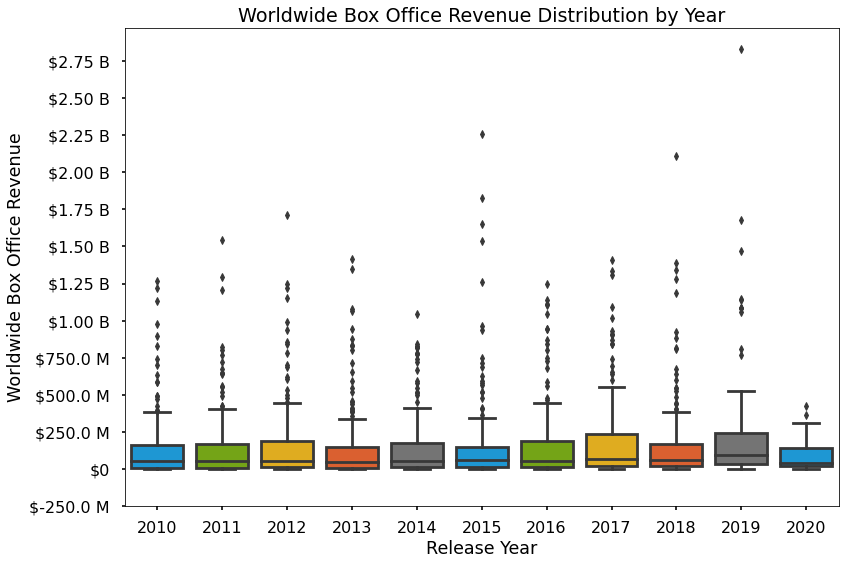

In [101]:
with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots()
    
    # Source: https://seaborn.pydata.org/generated/seaborn.boxplot.html
    sns.boxplot(x=df['release_year'], y=df['revenue_2020adj']
                , ax=ax, palette=ms_qualpalette)

    ax.set_title('Worldwide Box Office Revenue Distribution by Year');
    ax.set_xlabel('Release Year');
    ax.set_ylabel('Worldwide Box Office Revenue');

    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))
    
    ax.set_yticks(np.arange(-250000000, 3000000000, 250000000))

Box office revenues are skewed fairly heavily to the right, with many outliers in the upper ranges. I will use median as my primary measure of central tendency, since it is less susceptible to outliers.

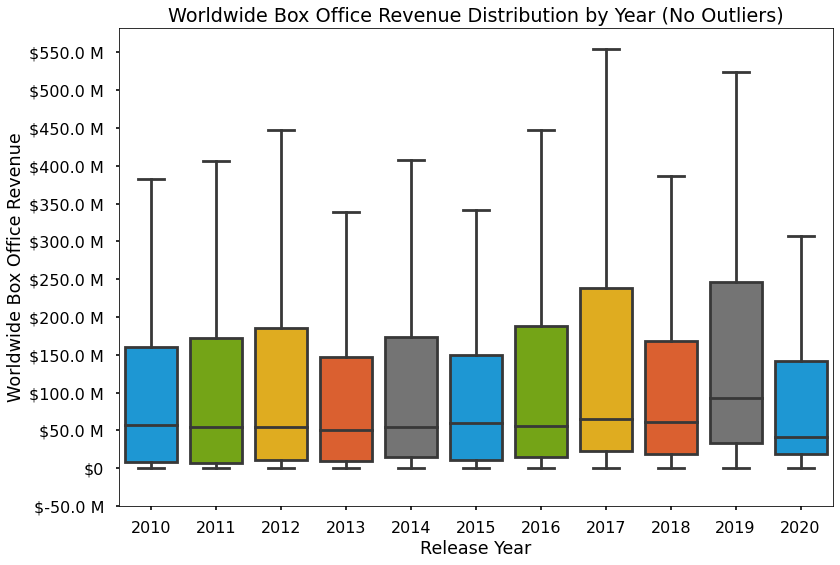

In [102]:
with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots()
    
    # Source: https://seaborn.pydata.org/generated/seaborn.boxplot.html
    sns.boxplot(x=df['release_year'], y=df['revenue_2020adj']
                , ax=ax, showfliers=False, palette=ms_qualpalette)

    ax.set_title('Worldwide Box Office Revenue Distribution by Year (No Outliers)');
    ax.set_xlabel('Release Year');
    ax.set_ylabel('Worldwide Box Office Revenue');

    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))
    
    ax.set_yticks(np.arange(-50000000, 600000000, 50000000))

In [103]:
df['revenue_2020adj'].describe()

count         1784.00
mean     160213273.20
std      268479942.30
min          11400.00
25%       13613792.91
50%       58794299.82
75%      177191742.55
max     2832316587.34
Name: revenue_2020adj, dtype: float64

In [104]:
df['revenue_2020adj'].median()

58794299.82390882

If we zoom in on the distributions without outliers, median revenues are fairly consistent year-over-year, hovering around \\$50 M most years.

50% of revenues over the past 10 years fall between \\$13.6 M and \\$177.2 M. 

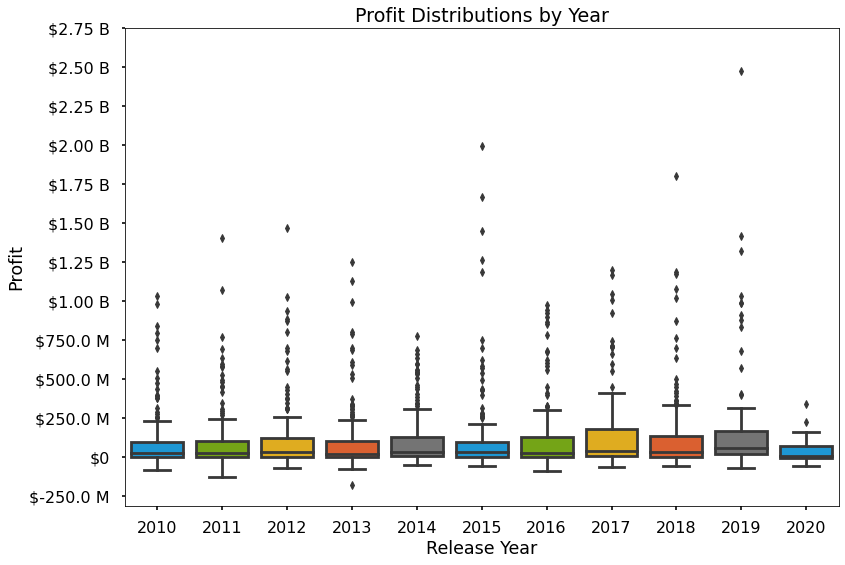

In [105]:
with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots()
    
    # Source: https://seaborn.pydata.org/generated/seaborn.boxplot.html
    sns.boxplot(x=df['release_year'], y=df['profit_2020adj']
                , ax=ax, palette=ms_qualpalette)

    ax.set_title('Profit Distributions by Year');
    ax.set_xlabel('Release Year');
    ax.set_ylabel('Profit');

    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))
    
    ax.set_yticks(np.arange(-250000000, 3000000000, 250000000))

Similarly to revenue, profit distributions are also skewed to the right with many outliers in the upper ranges. Median is the most appropriate measure of central tendency.

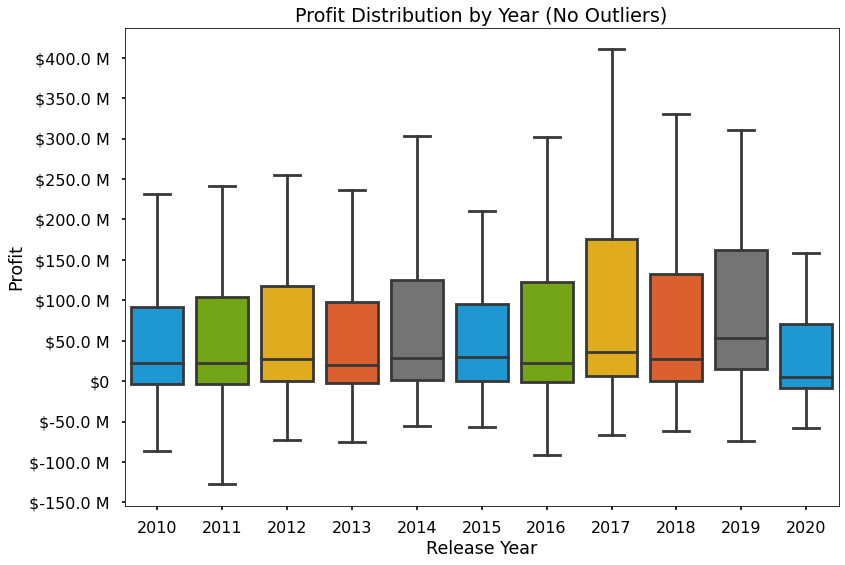

In [106]:
with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots()
    
    avg = df['profit_2020adj'].mean()
    
    # Source: https://seaborn.pydata.org/generated/seaborn.boxplot.html
    sns.boxplot(x=df['release_year'], y=df['profit_2020adj']
                , ax=ax, showfliers=False, palette=ms_qualpalette)

    ax.set_title('Profit Distribution by Year (No Outliers)');
    ax.set_xlabel('Release Year');
    ax.set_ylabel('Profit');

    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))
    
    ax.set_yticks(np.arange(-150000000, 450000000, 50000000))


In [107]:
df['profit_2020adj'].describe()

count         1784.00
mean     110429562.21
std      225624406.21
min     -184100903.18
25%        -452798.41
50%       27308749.51
75%      117938237.80
max     2471924671.61
Name: profit_2020adj, dtype: float64

In [108]:
df['profit_2020adj'].median()

27308749.51389894

Median profits hover around around \\$27 M, with 50% of revenues falling in the range between -\\$452 K and \\$117.94 M

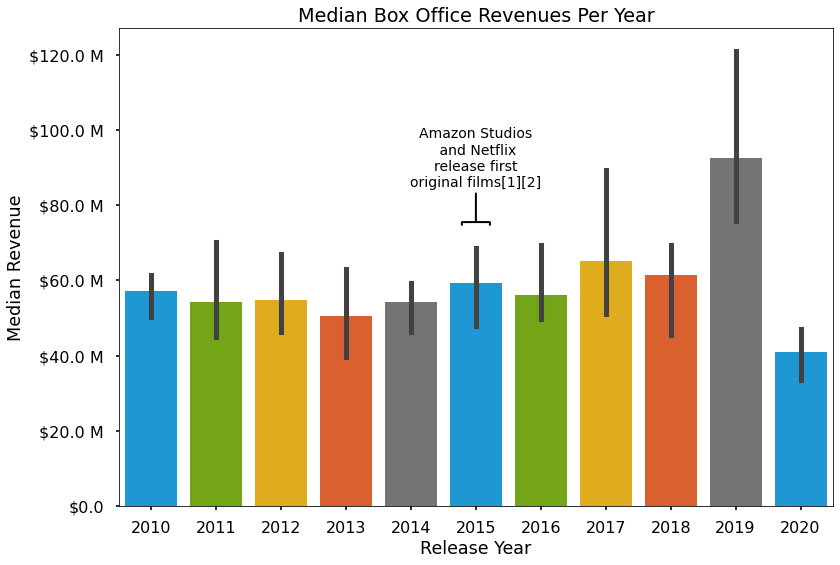

In [109]:
with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots()

    sns.barplot(x=df['release_year'], y=df['revenue_2020adj']
                , estimator=np.median, ax=ax, ci=68, palette=ms_qualpalette)

    ax.set_title('Median Box Office Revenues Per Year');
    ax.set_xlabel('Release Year');
    ax.set_ylabel('Median Revenue');

    ax.annotate("Amazon Studios\n and Netflix\nrelease first\noriginal films[1][2]", 
                xy=(5, 7.5*1e7),  xytext=(5, 8.5*1e7),
                arrowprops=dict(color='black', lw=2, arrowstyle='-[', ),
                horizontalalignment='center', size=14)
    
    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))

Box office revenues have remained fairly steady over the past 10 years, despite new studios releasing original content primarily online.

COVID-19 pandemic is likely a primary factor contributing to the dip in 2020, since theaters were closed in the US for most of the year. 

2020 also has a very high variability (tall error bar), so while median revenue was down overall, there were still some movies that made large amounts of revenue. This could be due to the way studios decided which movies to release (that were more likely to make high revenues) versus movies that were held back until after the pandemic or released online only. 


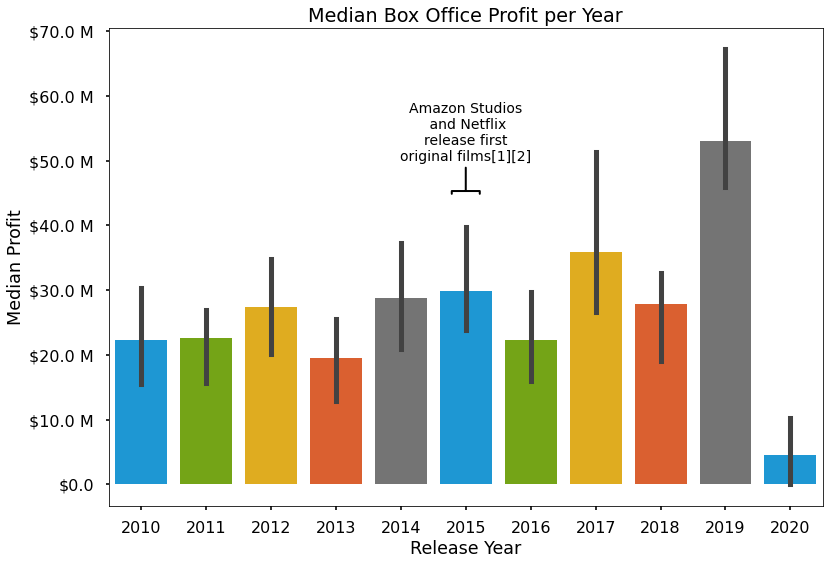

In [110]:
with plt.style.context('seaborn-poster'):
#    sns.set_palette(jcm_qualpalette)
    fig, ax = plt.subplots()

    sns.barplot(x=df['release_year'], y=df['profit_2020adj']
                , estimator=np.median, ax=ax, ci=68, palette=ms_qualpalette)

    ax.set_title('Median Box Office Profit per Year');
    ax.set_xlabel('Release Year');
    ax.set_ylabel('Median Profit');

    ax.annotate("Amazon Studios\n and Netflix\nrelease first\noriginal films[1][2]", 
                xy=(5, 4.5*1e7),  xytext=(5, 5*1e7),
                arrowprops=dict(color='black', lw=2, arrowstyle='-[', ),
                horizontalalignment='center', size=14)
    
    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))

Median profits are generally trending slightly up, again with the exception of 2020.

We can't yet predict whether box office revenues will return to previous levels. Since box office revenues significantly impact profits, we can't assume this upward trend will continue.

### Characteristics of Profitable Movies

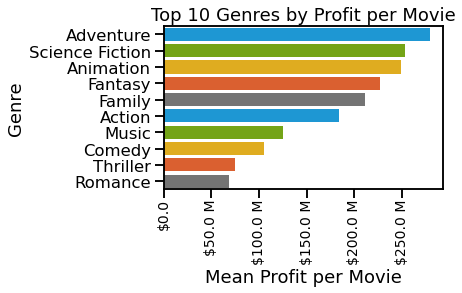

In [111]:
g_meanprofit = df_gp['profit_2020adj', 'mean'].sort_values(ascending=False)[:10]
    
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(5, 3));

sns.barplot(y=g_meanprofit.index, x=g_meanprofit, ax=ax, orient='h', 
            palette=ms_qualpalette);

ax.set_title('Top 10 Genres by Profit per Movie');
ax.set_xlabel('Mean Profit per Movie');
ax.set_ylabel('Genre');

#Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
#                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
ax.xaxis.set_major_formatter(plt.FuncFormatter(currency));
ax.tick_params(axis='x', labelsize=14, labelrotation=90, pad=0)

Adventure, Science Fiction, Animation, and Fantasy movies are the best genres to choose if Microsoft's primary goal is to maximize profits.

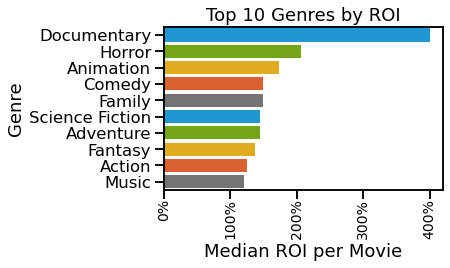

In [112]:
g_roi = df_gp['profitpercent_2020adj', 'median'].sort_values(ascending=False)[:10]

sns.set_context('talk')

fig, ax = plt.subplots(figsize=(5, 3));

sns.barplot(y=g_roi.index, x=g_roi, ax=ax, orient='h', 
            palette=ms_qualpalette);

ax.set_title('Top 10 Genres by ROI');
ax.set_xlabel('Median ROI per Movie');
ax.set_ylabel('Genre');

#Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
#                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p : '{:1.0f}%'.format(x)));
ax.tick_params(axis='x', labelsize=14, labelrotation=90, pad=0)

If the goal is to maximize ROI, Documentaries generate by far the highest, followed by Horror.

In [113]:
# Get cutoff for bottom 75% of budgets
df['budget_2020adj'].quantile(.75)

62728642.49202848

<ipython-input-114-870e9b63102d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


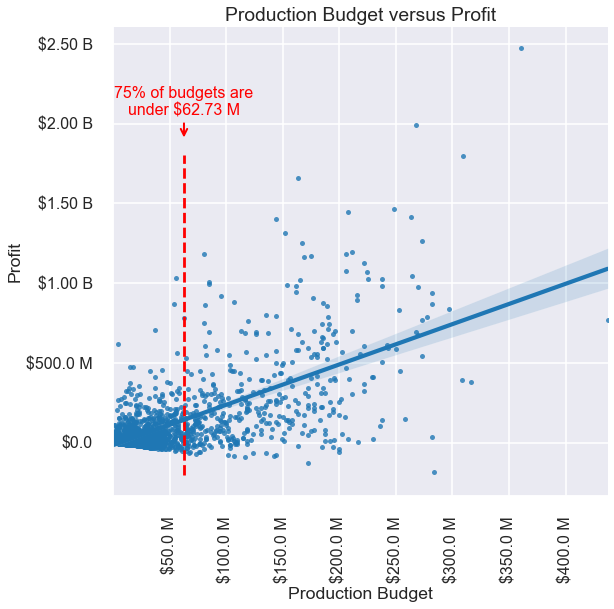

In [114]:
sns.set_style("darkgrid")

with plt.style.context('seaborn-poster'):
    g = sns.lmplot(x="budget_2020adj", y="profit_2020adj", 
                   height=8,
                   data=df, scatter_kws = {'s': 25}
                  )

    for ax in g.axes.flat:

        ax.set_title('Production Budget versus Profit');
        ax.set_xlabel('Production Budget');
        ax.set_ylabel('Profit');

        #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
        #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

        ax.xaxis.set_major_formatter(plt.FuncFormatter(currency))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))
        ax.vlines(df['budget_2020adj'].quantile(.75), colors='red', 
                  ymin=-2*1e8, ymax=1.8*1e9, linestyles='dashed')
        ax.annotate("75% of budgets are\nunder $62.73 M", color='red', 
                    xy=(df['budget_2020adj'].quantile(.75), 1.9*1e9),  
                    xytext=(df['budget_2020adj'].quantile(.75), 2.05*1e9),
                    arrowprops=dict(color='red', lw=2, arrowstyle='->', ),
                    horizontalalignment='center', size=16)

Movies with higher budgets generally make more profits.

For a chance at the highest profits, Microsoft should make movies with higher budgets.

The top 25% of budgets start at around \\$62.7 M, which is a reasonable floor for budgets to maximize profits.


In [115]:
# Get cutoff for bottom 25% of budgets
df['budget_2020adj'].quantile(.25)

10919512.102507416

<ipython-input-116-04e91fd9c6ca>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


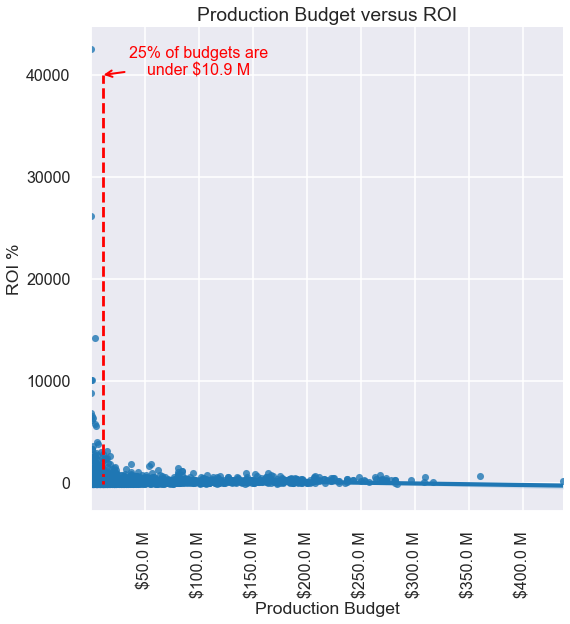

In [116]:
with plt.style.context('seaborn-poster'):
    g = sns.lmplot(x="budget_2020adj", y="profitpercent_2020adj", 
                   #col='budget_bottom25', 
                   height=8,# col_wrap=1,
                   data=df, scatter_kws = {'s': 50}
                  )

    for ax in g.axes.flat:

        ax.set_title('Production Budget versus ROI');
        ax.set_xlabel('Production Budget');
        ax.set_ylabel('ROI %');

        #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
        #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(currency))
        ax.vlines(df['budget_2020adj'].quantile(.25), colors='red', 
                  ymin=-100, ymax=40000, linestyles='dashed')
        ax.annotate("25% of budgets are\nunder $10.9 M", color='red', 
                    xy=(1e7, 40000),  
                    xytext=(1e8, 40000),
                    arrowprops=dict(color='red', lw=2, arrowstyle='->', ),
                    horizontalalignment='center', size=16)

In [117]:
genres_topprofit = ['Adventure', 'Animation', 'Science Fiction', 
                    'Fantasy']
genres_toproi = ['Documentary', 'Horror', 'Animation', 'Comedy']

<ipython-input-118-afbc91e6ba64>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


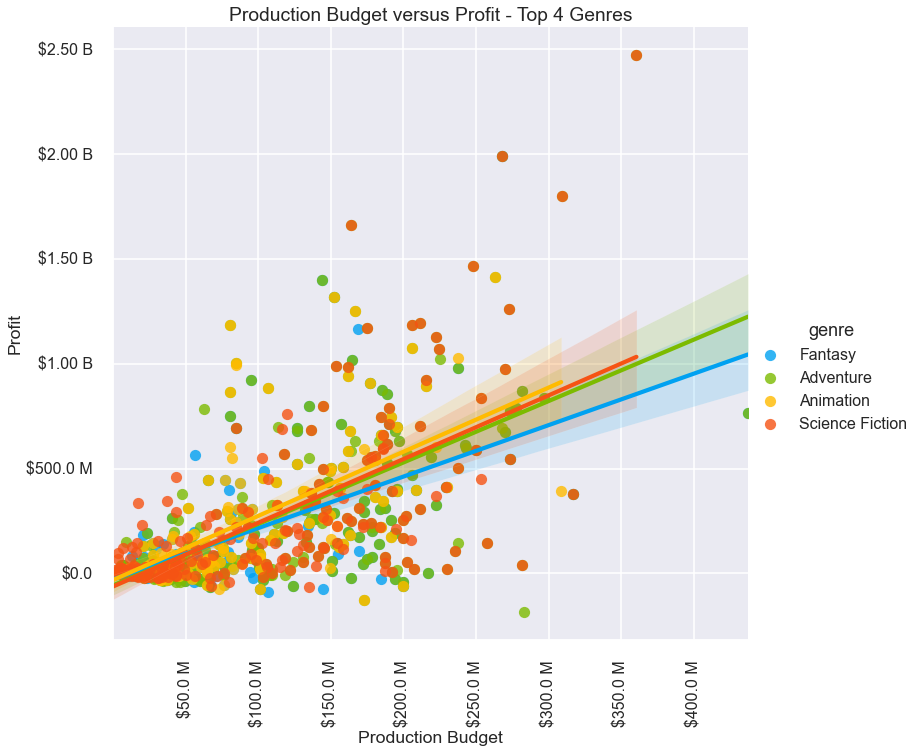

In [118]:
with plt.style.context('seaborn-poster'):
    g = sns.lmplot(x="budget_2020adj", y="profit_2020adj", 
                   hue="genre", palette=ms_qualpalette,
                   height=10, #col_wrap=2,
                   data=df_genres[df_genres['genre'].isin(genres_topprofit)])

    for ax in g.axes.flat:

        ax.set_title('Production Budget versus Profit - Top 4 Genres');
        ax.set_xlabel('Production Budget');
        ax.set_ylabel('Profit');

        #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
        #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(currency))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))

The budget versus ROI plots for top 4 genres don't differ much from the sample population or from each other, so I don't have any specific recommendations.

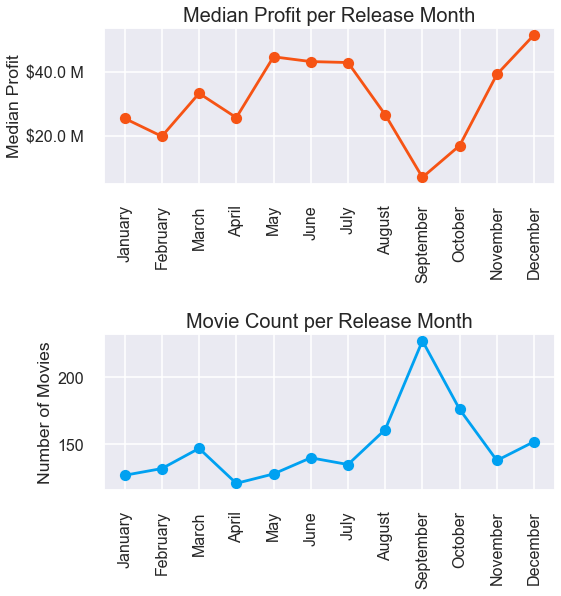

In [119]:
month_order = ['January','February','March','April','May','June',
             'July','August','September','October','November',
             'December']

with plt.style.context('seaborn-poster'):
    # Source: https://stackoverflow.com/questions/12589481/multiple-aggregations-
    # of-the-same-column-using-pandas-groupby-agg
    profit_by_month = df.groupby('release_month_num').agg(
        Median=('profit_2020adj', 'median'), 
        Count=('profit_2020adj', 'count'))

    fig, ([ax2, ax]) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    plt.tight_layout(pad=6)
    
    # Source: James Irving
    ax.plot(profit_by_month.index, profit_by_month.Count, marker='o', c='#00A1F1')
    ax2.plot(profit_by_month.index, profit_by_month.Median, marker='o', c='#F65314')
    
    # Specify we want to use seaborn to style the plot even though we're using
    # default matplotlib syntax
    # Source: https://www.codecademy.com/articles/seaborn-design-ii
    sns.set()

    # set and format labels
    ax.set_ylabel('Number of Movies');
    ax2.set_ylabel('Median Profit');
    ax.set_title('Movie Count per Release Month', 
                 fontdict={'fontsize':20})
    ax2.set_title('Median Profit per Release Month', 
                fontdict={'fontsize':20})

    ax.set_xticks(list(month_map.keys()));
    ax.set_xticklabels(list(month_map.values()), rotation=90);
    ax2.set_xticks(list(month_map.keys()));
    ax2.set_xticklabels(list(month_map.values()), rotation=90);
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(currency));

    

### Key Players in Successful Movies

Key contributors to a movie such as Directors, Writers, Actors and Actresses can be important to its success

While we can't truly quantify their contributions, below are initial "short lists" of contributors Microsoft should consider hiring for its movies, depending on whether the primary goal is to maximize profit, ROI, or audience ratings. 


In [120]:
# function to apply a blue font color to cells formatted as currency
# where the value is over a threshold
def overcurrlimit_blue(val, limit):
    # Source: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
    
    val_list= str.split(val, ' ')
    
    # Convert rounded abbreviated amount back to full value
    if val_list[1] == "B":
        val_float = float(val_list[0][1:])*1e9
    elif val_list[1] == "M":
        val_float = float(val_list[0][1:])*1e6
        
    color='blue' if val_float > limit else 'black'
    return 'color: %s' % color

In [121]:
# function to apply a blue font color to cells formatted as percents
# where the value is over a threshold
def overperlimit_blue(val, limit):
    # Source: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
        
    color='blue' if float(val[0:-1]) > limit else 'black'
    return 'color: %s' % color

In [122]:
# function to apply a blue font color to general numerical cells 
# where the value is over a threshold
def overratelimit_blue(val, limit):
    # Source: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
        
    color='blue' if val > limit else 'black'
    return 'color: %s' % color

In [123]:
# Get top 10 contributors by mean of their movies' profits
def gettopten_bymeanprofit(df_pivot, roles):
    
    dfs=[]
    
    for role in roles:

        # Create subdf from pivot listing only the top 10 in specified role
        # by mean profit
        top_df = df_pivot.loc[(role)][[('profit_2020adj', 'mean'),
                                                ('id','count')]].sort_values(
            by=[('profit_2020adj', 'mean')], ascending=False)[:10]

        # remove the top level of the hierarchical index
        top_df.columns = top_df.columns.get_level_values(1)

        # Make primary_name a column instead of the index
        top_df.reset_index(inplace=True)

        # rename the columns for presentation
        top_df.rename(columns={'mean':'Mean Movie Profit', 'count': 'Movie Count',
                             'primary_name': role + ' Name'}, inplace=True)

        # redo the index to start at 1 for presentation
        top_df.index = (range(1, len(top_df)+1))

        # Apply currency format to mean profit column
        top_df['Mean Movie Profit'] = top_df['Mean Movie Profit'].apply(currency)
        
        dfs.append(top_df)

    return dfs


In [124]:
# Get top 10 contributors by mean of their movies' ROI
def gettopten_bymeanroi(df_pivot, roles):
    
    dfs=[]
    
    for role in roles:

        # Create subdf from pivot listing only the top 10 in specified role
        # by mean roi
        top_df = df_pivot.loc[(role)][[('profitpercent_2020adj', 'mean'),
            ('id','count')]].sort_values(by=[('profitpercent_2020adj', 'mean')
                                            ], ascending=False)[:10]

        # remove the top level of the hierarchical index
        top_df.columns = top_df.columns.get_level_values(1)

        # Make primary_name a column instead of the index
        top_df.reset_index(inplace=True)

        # rename the columns for presentation
        top_df.rename(columns={'mean':'Mean Movie ROI', 'count': 'Movie Count',
                             'primary_name': role + ' Name'}, inplace=True)

        # redo the index to start at 1 for presentation
        top_df.index = (range(1, len(top_df)+1))

        # Apply percent format to mean ROI column
        top_df['Mean Movie ROI'] = top_df['Mean Movie ROI'].apply(lambda x : f'{np.round(x,1)}%')

        dfs.append(top_df)

    return dfs


In [125]:
# Get top 10 contributors by mean of their movies' ratings
def gettopten_bymeanrate(df_pivot, roles):

    dfs=[]
    
    for role in roles:
        # Create subdf from pivot listing only the top 10 in specified role
        # by mean rating
        top_df = df_pivot.loc[(role)][[('imdb_averagerating', 'mean'),('id','count'
              )]].sort_values(by=[('imdb_averagerating', 'mean')], ascending=False)[:10]

        # remove the top level of the hierarchical index
        top_df.columns = top_df.columns.get_level_values(1)

        # Make primary_name a column instead of the index
        top_df.reset_index(inplace=True)

        # rename the columns for presentation
        top_df.rename(columns={'mean':'Mean Movie Rating', 'count': 'Movie Count',
                             'primary_name':role + ' Name'}, inplace=True)

        # redo the index to start at 1 for presentation
        top_df.index = (range(1, len(top_df)+1))

        dfs.append(top_df)

    return dfs

In [126]:
# Get contributors who worked on at least 2 movies, and where their
# movies ranked in the top 1% of profits
def gettoppercent_bymeanprofit(df_pivot, roles):
    
    dfs=[]
    
    for role in roles:

        # Create subdf from pivot listing only ones who worked on multiple
        # movies, where the mean profit for those movies is more than 99% of
        # all the movies we analyzed
        top_df = df_pivot.loc[(role)][[(
            'profit_2020adj', 'mean'),(
            'id','count')]]
        top_df = top_df.loc[(
            top_df[('profit_2020adj', 'mean')] > profit_99cutoff) & (
            top_df[('id','count')] > 1)]

        # remove the top level of the hierarchical index
        top_df.columns = top_df.columns.get_level_values(1)

        # Make primary_name a column instead of the index
        top_df.reset_index(inplace=True)

        # rename the columns for presentation
        top_df.rename(columns={'mean':'Mean Movie Profit', 'count': 'Movie Count',
                             'primary_name': role + ' Name'}, inplace=True)

        # redo the index to start at 1 for presentation
        top_df.index = (range(1, len(top_df)+1))

        # Apply currency format to mean profit column
        top_df['Mean Movie Profit'] = top_df['Mean Movie Profit'].apply(currency)
        
        dfs.append(top_df)

    return dfs


In [127]:
# Get contributors who worked on at least 2 movies, and where their
# movies ranked in the top 1% of ROI
def gettoppercent_bymeanroi(df_pivot, roles):
    
    dfs=[]
    
    for role in roles:

        # Create subdf from pivot listing only ones who worked on multiple
        # movies, where the mean roi for those movies is more than 99% of
        # all the movies we analyzed
        top_df = df_pivot.loc[(role)][[(
            'profitpercent_2020adj', 'mean'),(
            'id','count')]]
        top_df = top_df.loc[(
            top_df[('profitpercent_2020adj', 'mean')] > roi_99cutoff) & (
            top_df[('id','count')] > 1)]

        # remove the top level of the hierarchical index
        top_df.columns = top_df.columns.get_level_values(1)

        # Make primary_name a column instead of the index
        top_df.reset_index(inplace=True)

        # rename the columns for presentation
        top_df.rename(columns={'mean':'Mean Movie ROI', 'count': 'Movie Count',
                             'primary_name': role + ' Name'}, inplace=True)

        # redo the index to start at 1 for presentation
        top_df.index = (range(1, len(top_df)+1))

        # Apply percent format to mean ROI column
        top_df['Mean Movie ROI'] = top_df['Mean Movie ROI'].apply(lambda x : f'{np.round(x,1)}%')

        dfs.append(top_df)

    return dfs


In [128]:
# Get contributors who worked on at least 2 movies, and where their
# movies ranked in the top 1% of ratings
def gettoppercent_bymeanrate(df_pivot, roles):

    dfs=[]
    
    for role in roles:
        # Create subdf from pivot listing only ones who worked on multiple
        # movies, where the mean rating for those movies is more than 99% of
        # all the movies we analyzed
        top_df = df_pivot.loc[(role)][[(
            'imdb_averagerating', 'mean'),(
            'id','count')]]
        top_df = top_df.loc[(
            top_df[('imdb_averagerating', 'mean')] > rate_99cutoff) & (
            top_df[('id','count')] > 1)]


        # remove the top level of the hierarchical index
        top_df.columns = top_df.columns.get_level_values(1)

        # Make primary_name a column instead of the index
        top_df.reset_index(inplace=True)

        # rename the columns for presentation
        top_df.rename(columns={'mean':'Mean Movie Rating', 'count': 'Movie Count',
                             'primary_name':role + ' Name'}, inplace=True)

        # redo the index to start at 1 for presentation
        top_df.index = (range(1, len(top_df)+1))

        dfs.append(top_df)

    return dfs

First, I created lists of the top 10 contributors, and highlighted the mean statistic if it was in the top 1%. 

However, I noticed that a lot of these were using only one movie as a sample, which may not be diverse enough.

In [129]:
# Create top 10 dataframes by mean profit for the specified roles
dfs_pres = gettopten_bymeanprofit(df_cred_pvt, 
                                 ['Director', 'Writer', 'Actor', 'Actress'])

In [130]:
# top ten directors by mean profit
dfs_pres[0].style.applymap(lambda x: overcurrlimit_blue(x, profit_99cutoff)
                          , subset='Mean Movie Profit')

,Director Name,Mean Movie Profit,Movie Count
1,Joe Russo,$1.46 B,4
2,Anthony Russo,$1.46 B,4
3,Joss Whedon,$1.36 B,2
4,Jennifer Lee,$1.28 B,2
5,Chris Buck,$1.28 B,2
6,J.J. Abrams,$1.04 B,3
7,Eric Guillon,$1.00 B,1
8,Jared Bush,$942.2 M,1
9,Pierre Coffin,$933.1 M,4
10,Josh Cooley,$909.5 M,1


In [131]:
# top ten writers by mean profit
dfs_pres[1].style.applymap(lambda x: overcurrlimit_blue(x, profit_99cutoff)
                          , subset='Mean Movie Profit')

,Writer Name,Mean Movie Profit,Movie Count
1,Michael Crichton,$1.41 B,2
2,J.J. Abrams,$1.41 B,2
3,Jim Starlin,$1.38 B,5
4,Shane Morris,$1.25 B,1
5,Chris Buck,$1.25 B,1
6,Hans Christian Andersen,$1.25 B,1
7,Colin Trevorrow,$1.22 B,3
8,Joe Robert Cole,$1.18 B,1
9,Gabrielle-Suzanne Barbot de Villeneuve,$1.17 B,1
10,Don Heck,$1.14 B,3


In [132]:
# top ten actors by mean profit
dfs_pres[2].style.applymap(lambda x: overcurrlimit_blue(x, profit_99cutoff)
                          , subset='Mean Movie Profit')

,Actor Name,Mean Movie Profit,Movie Count
1,Jonathan Groff,$1.28 B,2
2,Pierre Coffin,$1.18 B,1
3,Rafe Spall,$1.17 B,1
4,Rupert Grint,$1.12 B,2
5,Craig T. Nelson,$1.07 B,1
6,Huck Milner,$1.07 B,1
7,Ned Beatty,$1.03 B,1
8,Trey Parker,$1.00 B,1
9,Jordan Peele,$909.5 M,1
10,Robert Downey Jr.,$905.8 M,12


In [133]:
# top ten actresses by mean profit
dfs_pres[3].style.applymap(lambda x: overcurrlimit_blue(x, profit_99cutoff)
                          , subset='Mean Movie Profit')

,Actress Name,Mean Movie Profit,Movie Count
1,Daisy Ridley,$1.34 B,3
2,Idina Menzel,$1.25 B,1
3,Carrie Fisher,$1.20 B,1
4,Sarah Vowell,$1.07 B,1
5,Holly Hunter,$1.07 B,1
6,Rosie Huntington-Whiteley,$1.07 B,1
7,Zazie Beetz,$1.03 B,1
8,Miranda Cosgrove,$999.4 M,2
9,Jenny Slate,$942.2 M,1
10,Kaitlin Olson,$893.5 M,1


In [134]:
# Create top 10 dataframes by mean roi for the specified roles
dfs_pres = gettopten_bymeanroi(df_cred_pvt, 
                                 ['Director', 'Writer', 'Actor', 'Actress'])

In [135]:
# Top ten directors based on mean roi
dfs_pres[0].style.applymap(lambda x: overperlimit_blue(x, roi_99cutoff)
                          , subset='Mean Movie ROI')# Top ten writers based on mean roi

,Director Name,Mean Movie ROI,Movie Count
1,Travis Cluff,42564.4%,1
2,Chris Lofing,42564.4%,1
3,Olivia M. Lamasan,26182.0%,1
4,Sam Taylor-Johnson,14175.2%,1
5,John Pogue,8817.4%,1
6,Omung Kumar,6834.1%,1
7,Aneesh Chaganty,6526.5%,1
8,Levan Gabriadze,6188.2%,1
9,Tod Williams,5817.1%,1
10,Henry Joost,4299.7%,4


In [136]:
# Top ten writers based on mean roi
dfs_pres[1].style.applymap(lambda x: overperlimit_blue(x, roi_99cutoff)
                          , subset='Mean Movie ROI')

,Writer Name,Mean Movie ROI,Movie Count
1,Chris Lofing,42564.4%,1
2,Travis Cluff,42564.4%,1
3,Olivia M. Lamasan,26182.0%,1
4,Vanessa R. Valdez,26182.0%,1
5,William Brent Bell,10075.8%,1
6,Matthew Peterman,10075.8%,1
7,John Pogue,8817.4%,1
8,Craig Rosenberg,8817.4%,1
9,Tom de Ville,8817.4%,1
10,Ramendra Vasishth,6834.1%,1


In [137]:
# Top ten actors based on mean roi
dfs_pres[2].style.applymap(lambda x: overperlimit_blue(x, roi_99cutoff)
                          , subset='Mean Movie ROI')

,Actor Name,Mean Movie ROI,Movie Count
1,Reese Mishler,42564.4%,1
2,Ryan Shoos,42564.4%,1
3,Ronaldo Valdez,26182.0%,1
4,John Lloyd Cruz,26182.0%,1
5,Evan Helmuth,10075.8%,1
6,Simon Quarterman,10075.8%,1
7,Ionut Grama,10075.8%,1
8,Sunil Thapa,6834.1%,1
9,Robin Das,6834.1%,1
10,Joseph Lee,6526.5%,1


In [138]:
# Top ten actresses based on mean roi
dfs_pres[3].style.applymap(lambda x: overperlimit_blue(x, roi_99cutoff)
                          , subset='Mean Movie ROI')

,Actress Name,Mean Movie ROI,Movie Count
1,Pfeifer Brown,42564.4%,1
2,Cassidy Gifford,42564.4%,1
3,Bea Alonzo,26182.0%,1
4,Hilda Koronel,26182.0%,1
5,Jennifer Ehle,14175.2%,1
6,Fernanda Andrade,10075.8%,1
7,Erin Richards,8817.4%,1
8,Rajni Basumatary,6834.1%,1
9,Debra Messing,6526.5%,1
10,Michelle La,6526.5%,1


In [139]:
# Create top 10 dataframes by mean rating for the specified roles
dfs_pres = gettopten_bymeanrate(df_cred_pvt, 
                                 ['Director', 'Writer', 'Actor', 'Actress'])

In [140]:
# Top ten directors based on mean rating
dfs_pres[0].style.applymap(lambda x: overratelimit_blue(x, rate_99cutoff)
                      , subset='Mean Movie Rating')

,Director Name,Mean Movie Rating,Movie Count
1,Zolbayar Dorj,9.400000,1
2,Quentin Tarantino,8.633333,3
3,Éric Toledano,8.500000,1
4,Nitesh Tiwari,8.500000,1
5,Rodney Rothman,8.500000,1
6,Bob Persichetti,8.500000,1
7,Olivier Nakache,8.500000,1
8,Christopher Nolan,8.425000,5
9,Sandeep Reddy Vanga,8.400000,1
10,Adrian Molina,8.400000,1


In [141]:
# Top ten writers based on mean rating
dfs_pres[1].style.applymap(lambda x: overratelimit_blue(x, rate_99cutoff)
                      , subset='Mean Movie Rating')

,Writer Name,Mean Movie Rating,Movie Count
1,Zolbayar Dorj,9.400000,1
2,Scott Powers Houston,9.400000,1
3,Buyantsogt Ganbold,9.400000,1
4,Dae-hwan Kim,8.700000,1
5,Max Eggers,8.700000,1
6,Jin Won Han,8.700000,1
7,Quentin Tarantino,8.633333,3
8,Shreyas Jain,8.500000,1
9,Nikhil Mehrotra,8.500000,1
10,Nitesh Tiwari,8.500000,1


In [142]:
# Top ten actors based on mean rating
dfs_pres[2].style.applymap(lambda x: overratelimit_blue(x, rate_99cutoff)
                      , subset='Mean Movie Rating')

,Actor Name,Mean Movie Rating,Movie Count
1,Dorj Dambii,9.400000,1
2,Dorjsambuu Dambii,9.400000,1
3,Sharavdorj Dambii,9.400000,1
4,Woo-sik Choi,8.700000,1
5,Kang-ho Song,8.700000,1
6,Sun-kyun Lee,8.700000,1
7,François Cluzet,8.500000,1
8,Paul Reiser,8.500000,1
9,Omar Sy,8.500000,1
10,Anthony Gonzalez,8.400000,1


In [143]:
# Top ten actresses based on mean rating
dfs_pres[3].style.applymap(lambda x: overratelimit_blue(x, rate_99cutoff)
                      , subset='Mean Movie Rating')

,Actress Name,Mean Movie Rating,Movie Count
1,Brittany Belt,9.400000,1
2,Yeo-jeong Jo,8.700000,1
3,Melissa Benoist,8.500000,1
4,Sakshi Tanwar,8.500000,1
5,Sanya Malhotra,8.500000,1
6,Audrey Fleurot,8.500000,1
7,Fatima Sana Shaikh,8.500000,1
8,Anne Le Ny,8.500000,1
9,Shalini Pandey,8.400000,1
10,Alanna Ubach,8.400000,1


The below tables represent the contributors who worked on at least 2 movies in the past 10 years, and whose movies performed in the top 1% based on profit, ROI, and ratings.

I chose to only select those in the top 1% because that's most likely to be significant. I also chose to filter for instances where the contributors worked on at least 2 movies, since a lot of the calculations I was getting in top ten were only for a single movie, which isn't diverse enough.

In [144]:
# Get contributors who worked on multiple movies in the past ten years,
# and the average profit of their movies is higher than 99% of movies we analyzed
dfs_pres = gettoppercent_bymeanprofit(df_cred_pvt, [
    'Director', 'Writer', 'Actor', 'Actress'])


In [145]:
# Top directors by mean movie profit
dfs_pres[0]

,Director Name,Mean Movie Profit,Movie Count
1,Anthony Russo,$1.46 B,4
2,Chris Buck,$1.28 B,2
3,Jennifer Lee,$1.28 B,2
4,Joe Russo,$1.46 B,4
5,Joss Whedon,$1.36 B,2


In [146]:
# Top writers by mean movie profit
dfs_pres[1]

,Writer Name,Mean Movie Profit,Movie Count
1,Colin Trevorrow,$1.22 B,3
2,Don Heck,$1.14 B,3
3,J.J. Abrams,$1.41 B,2
4,Jim Starlin,$1.38 B,5
5,Michael Crichton,$1.41 B,2


In [147]:
# Top actors by mean movie profit
dfs_pres[2]

,Actor Name,Mean Movie Profit,Movie Count
1,Jonathan Groff,$1.28 B,2
2,Rupert Grint,$1.12 B,2


In [148]:
# Top actresses by mean movie profit
dfs_pres[3]

,Actress Name,Mean Movie Profit,Movie Count
1,Daisy Ridley,$1.34 B,3


In [149]:
# Get contributors who worked on multiple movies in the past ten years,
# and the average profit of their movies is higher than 99% of movies we analyzed
dfs_pres2 = gettoppercent_bymeanroi(df_cred_pvt, [
    'Director', 'Writer', 'Actor', 'Actress'])

In [150]:
# Top directors by mean movie roi
dfs_pres2[0]

,Director Name,Mean Movie ROI,Movie Count
1,Ariel Schulman,4299.7%,4
2,Henry Joost,4299.7%,4
3,Jordan Peele,3375.6%,2
4,William Brent Bell,3573.6%,3


In [151]:
# Top writers by mean movie roi
dfs_pres2[1]

,Writer Name,Mean Movie ROI,Movie Count
1,E.L. James,5111.2%,3
2,Jordan Peele,3375.6%,2
3,Kelly Marcel,5011.3%,3
4,Oren Moverman,4362.8%,2


In [152]:
# Top actors by mean movie roi
dfs_pres2[2]

,Actor Name,Mean Movie ROI,Movie Count
1,Jamie Dornan,3821.2%,4
2,Ty Simpkins,3690.9%,2


In [153]:
# Top actresses by mean movie roi
dfs_pres2[3]

,Actress Name,Mean Movie ROI,Movie Count
1,Eloise Mumford,5111.2%,3
2,Katie Featherston,4286.7%,2
3,Lin Shaye,3969.6%,2
4,Olivia Cooke,3674.1%,3


In [154]:
# Get contributors who worked on multiple movies in the past ten years,
# and the average profit of their movies is higher than 99% of movies we analyzed
dfs_pres3 = gettoppercent_bymeanrate(df_cred_pvt, [
    'Director', 'Writer', 'Actor', 'Actress'])

In [155]:
# Top directors by mean movie rating
dfs_pres3[0]

,Director Name,Mean Movie Rating,Movie Count
1,Christopher Nolan,8.43,5
2,Lee Unkrich,8.35,2
3,Quentin Tarantino,8.63,3


In [156]:
# Top writers by mean movie rating
dfs_pres3[1]

,Writer Name,Mean Movie Rating,Movie Count
1,Jonathan Nolan,8.50,2
2,Lee Unkrich,8.35,2
3,Quentin Tarantino,8.63,3


In [157]:
# Top actors by mean movie rating
dfs_pres3[2]

,Actor Name,Mean Movie Rating,Movie Count
1,Aamir Khan,8.35,2


In [158]:
# Top actresses by mean movie rating
dfs_pres3[3]

,Actress Name,Mean Movie Rating,Movie Count


## Conclusions

Over the past ten years, movies typically made (in 2020 US dollars) \\$13.6 M to \\$177.2 M in box office revenue, and -\\$452 K to \\$117.94 M in profit.

However, it's still uncertain how the COVID-19 pandemic will affect box office revenues in the future. Past trends in box office revenue and profits may not pick up where they left off.

### Recommendations to maximize profits
- Focus on Adventure, Science Fiction, Animation, or Fantasy genres
- Make higher budget movies, over approximately //$62.7M


### Recommendations to maximize ROI
- Focus on Documentaries, with Horror films as a distant second
- Make lower budget movies, under approximately //$10.9M

### General Recommendations
- Target pre-holiday season (November, December), or early summer (May, June, July) to release movies to theaters
- Avoid releasing movies in September and October
- Consider hiring directors, writers, actors, and actresses who have contributed to movies with profit, ROI, and ratings in the top 1% of our sample

### Suggestions for further analysis
- If possible, obtain more financial data related to:
    - Average cut of box office proceeds that go to studios
    - Average spend on advertising and promotion
    - Average revenue post-theatrical-release (streaming, video-on-demand, etc)
- A closer look at factors contributing to high user ratings, critical ratings and award nominations
- Analysis of how runtime and MPAA ratings contribute to profit and ROI
- Investigate whether certain words or linguistic properties in titles contribute to higher profits or ROI
